---

## Matthieu Kaeppelin

## Projet Kaggle - Segmentation et classification de lésions cutanées

## Télécom 2024

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import cv2 as cv
import os
import DarkArtefactRemoval as dca
import dullrazor as dr
import segmentation_and_preprocessing as sp
from tqdm import tqdm

# I -  Loading Data

In [2]:
# Répertoire contenant les images
image_dir_train = 'Train/Train/'
image_dir_test = 'Test/Test/'

Train_path = image_dir_train

import glob
images_train = glob.glob(Train_path + '/*[0-9].jpg')
mask_img_train = glob.glob(Train_path + '/*seg.png')

images_with_mask = [ Train_path + mask_img_train[i].split('/')[-1].split('_seg')[0] + '.jpg' for i in range(len(mask_img_train))]
images_test = glob.glob(image_dir_test + '/*[0-9].jpg')
mask_img_test = glob.glob(image_dir_test + '/*seg.png')

#Lire le csv metadataTrain et metadataTest
metadataTrain = pd.read_csv('metadataTrain.csv')
metadataTest = pd.read_csv('metadataTest.csv')



In [3]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(images_with_mask),  'train images with mask')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks


# II - Exploring Data

### Let's take a look to the metadata we have

In [4]:
metadataTrain.head()

,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0028766,2,male,30.0,NaN
1,ISIC_0071222,8,male,85.0,lower extremity
2,ISIC_0069434,3,male,85.0,head/neck
3,ISIC_0062098,1,male,55.0,head/neck
4,ISIC_0057224,8,female,45.0,lower extremity


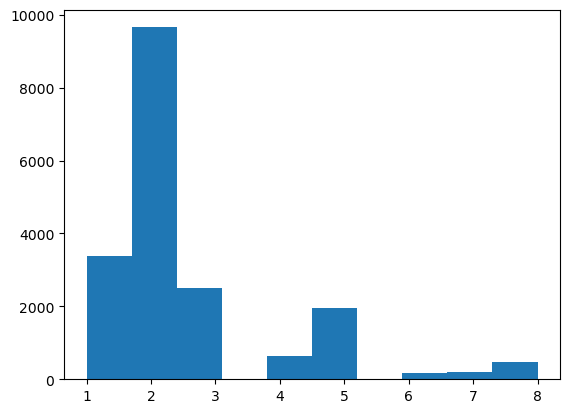

In [6]:
plt.hist(metadataTrain['CLASS'])
plt.show()

# Dark artefact removal

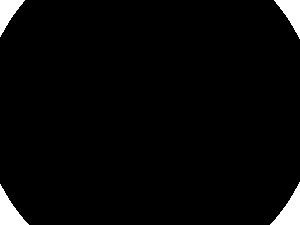

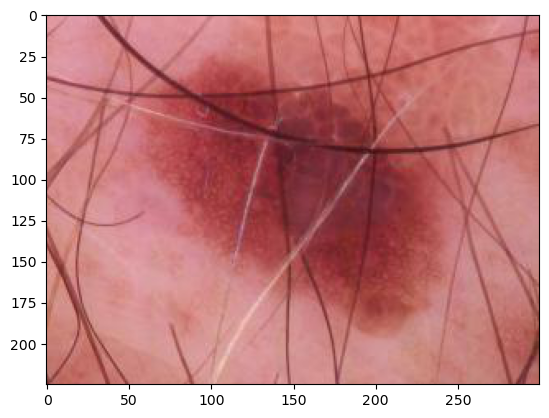

In [6]:
image = io.imread('Train/Train/ISIC_0030680.jpg')
plt.imshow(image)
dca.get_mask(image)

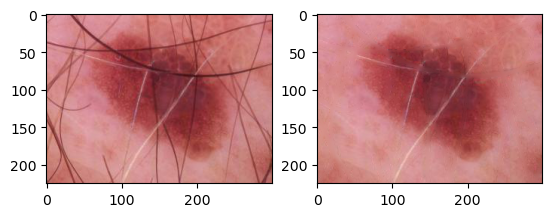

In [7]:
image = io.imread(images_train[0])
img_cleaned = dr.dullrazor(image)
img_cleaned = cv.cvtColor(img_cleaned, cv.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(img_cleaned)
plt.show()

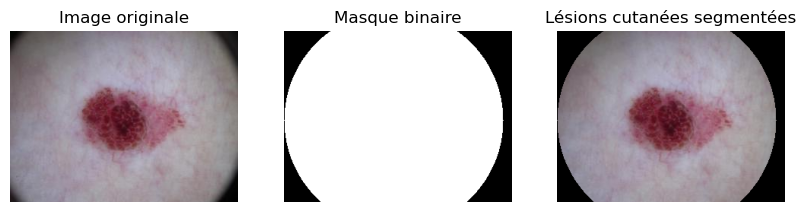

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image = cv2.imread(images_train[1])

# Charger le masque binaire
masque = np.array(dca.get_mask(image))
masque = cv2.bitwise_not(masque)

# Segmenter les lésions cutanées en utilisant le masque
lesions = cv2.bitwise_and(image, image, mask=masque)

# Afficher les résultats
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image originale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masque, cmap='gray')
plt.title('Masque binaire')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(lesions, cv2.COLOR_BGR2RGB))
plt.title('Lésions cutanées segmentées')
plt.axis('off')

plt.show()


In [9]:
def inpainting_dca(image):
    # Perform DCA
    dca_mask = dca.get_mask(image)
    dca_mask_np = np.array(dca_mask, dtype=np.uint8)

    inpainted_image = cv.inpaint(image, dca_mask_np, 3, cv.INPAINT_TELEA)

    return inpainted_image

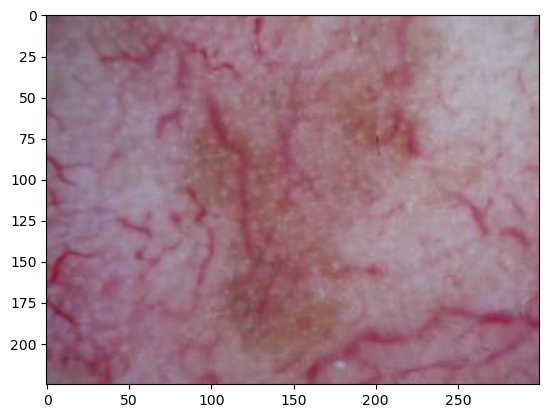

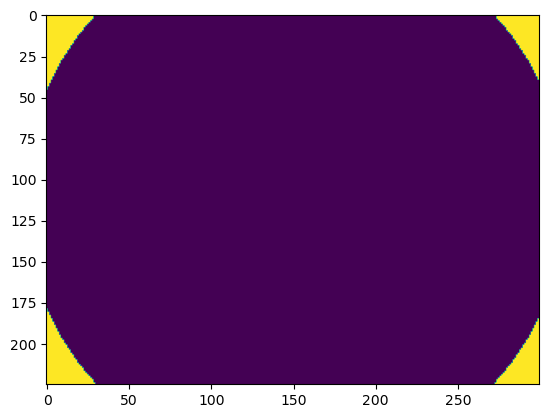

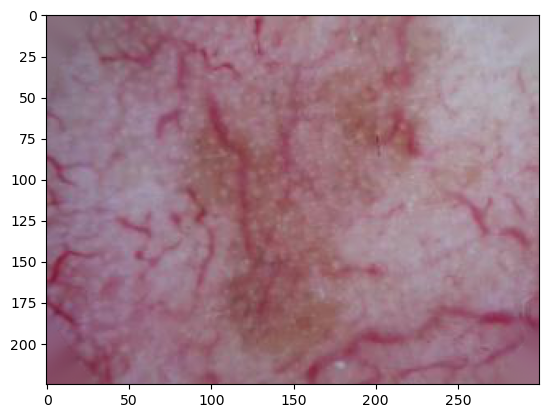

In [10]:
image = io.imread(images_train[5])
mask = dca.get_mask(image)

plt.imshow(image)
plt.show()

plt.imshow(mask)
plt.show()

inpainted_image = inpainting_dca(image)
plt.imshow(inpainted_image)
plt.show()


In [11]:
from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects


image = img_cleaned

def five_segmentation(image):
    # Seuillage avec le canal bleu (RVB)
    blue_channel = image[:, :, 0]
    _, thresholded_blue = cv.threshold(blue_channel, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    thresholded_blue = cv.bitwise_not(thresholded_blue)/255

    # Seuillage avec le canal b (CIE-Lab)
    lab_image = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    b_channel = lab_image[:, :, 2]
    _, thresholded_b = cv.threshold(b_channel, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    thresholded_b = cv.bitwise_not(thresholded_b)/255

    # Regroupement des couleurs 3D avec CIE-XYZ
    xyz_image = cv.cvtColor(image, cv.COLOR_BGR2XYZ)
    xyz_features = xyz_image.reshape((-1, 3))
    x,y,z = cv.split(xyz_image)
    # Reshape x, y, z back to their original 2D shapes
    x = x.reshape(image.shape[:2])
    y = y.reshape(image.shape[:2])
    z = z.reshape(image.shape[:2])

    #threshold sur x, y, z
    _, thresholded_x = cv.threshold(x, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    thresholded_x = cv.bitwise_not(thresholded_x)/255
    _, thresholded_y = cv.threshold(y, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    thresholded_y = cv.bitwise_not(thresholded_y)/255
    _, thresholded_z = cv.threshold(z, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    thresholded_z = cv.bitwise_not(thresholded_z)/255

    return thresholded_blue, thresholded_b, thresholded_x, thresholded_y, thresholded_z






In [12]:
import cv2
import cv2
import numpy as np

# Remove small elements of the segmentation mask
def remove_small_parts_and_fill(five_masks,min_size=1000):
    five_masks_list = list(five_masks)
    #Opening
    radius = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))

    for i in range(len(five_masks_list)):
        five_masks_list[i] = five_masks_list[i].astype(np.uint8)
        #Opening
        five_masks_list[i] = cv2.morphologyEx(five_masks_list[i], cv2.MORPH_CLOSE, kernel)
        five_masks_list[i] = five_masks_list[i].astype(bool)
        five_masks_list[i] = remove_small_objects(five_masks_list[i], min_size=min_size)
    return five_masks_list


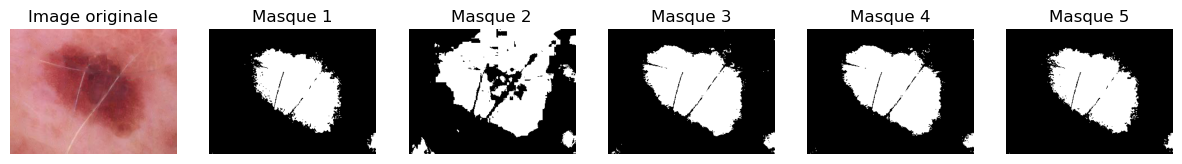

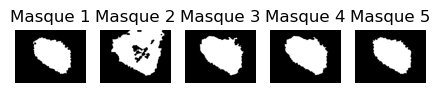

In [13]:
image = io.imread(images_train[0])
image_cleaned = dr.dullrazor(image)
image_cleaned_rgb = cv.cvtColor(image_cleaned, cv.COLOR_BGR2RGB)  # Convertir en RGB avant d'afficher
five_masks = five_segmentation(image_cleaned_rgb)  
five_masks_cleaned = remove_small_parts_and_fill(five_masks)

#Affichage des 5 masques
plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow(image_cleaned_rgb)
plt.title('Image originale')
plt.axis('off')

for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(five_masks[i], cmap='gray')
    plt.title('Masque '+str(i+1))
    plt.axis('off')
plt.show()

#Affichage des 5 masques après nettoyage
for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(five_masks_cleaned[i], cmap='gray')
    plt.title('Masque '+str(i+1))
    plt.axis('off')


*1-* Segmentation results with the lesion mask growing into the image border are rejected;

*2* Segmentation results without any detected region are rejected;

*3-* Segmentation results comprising fragments at the image borders are rejected;

*4-* The segmentation result with the smallest mask is rejected;

*5-* Segmentation results, whose mask areas differ too much to the other segmentation results are rejected;


In [14]:
image = io.imread(images_train[0])
image_cleaned = dr.dullrazor(image)
image_cleaned_rgb = cv.cvtColor(image_cleaned, cv.COLOR_BGR2RGB)  # Convertir en RGB avant d'afficher
five_masks = five_segmentation(image_cleaned_rgb)    

def union_mask(five_masks):
    mask_state = [True, True, True, True, True]

    #Rule 1 : Segmentation results with the lesion mask growing into the image border are rejected
    # Check if the lesion mask grows into the image border
    if np.any(five_masks[0][0, :]) or np.any(five_masks[0][-1, :]) or np.any(five_masks[0][:, 0]) or np.any(five_masks[0][:, -1]):
        mask_state[0] = False
        print("mask_state[0] = False")
    if np.any(five_masks[1][0, :]) or np.any(five_masks[1][-1, :]) or np.any(five_masks[1][:, 0]) or np.any(five_masks[1][:, -1]):
        mask_state[1] = False
        print("mask_state[1] = False")
    if np.any(five_masks[2][0, :]) or np.any(five_masks[2][-1, :]) or np.any(five_masks[2][:, 0]) or np.any(five_masks[2][:, -1]):
        mask_state[2] = False
        print("mask_state[2] = False")
    if np.any(five_masks[3][0, :]) or np.any(five_masks[3][-1, :]) or np.any(five_masks[3][:, 0]) or np.any(five_masks[3][:, -1]):
        mask_state[3] = False
        print("mask_state[3] = False")
    if np.any(five_masks[4][0, :]) or np.any(five_masks[4][-1, :]) or np.any(five_masks[4][:, 0]) or np.any(five_masks[4][:, -1]):
        mask_state[4] = False
        print("mask_state[4] = False")

    print(mask_state, " rule 1")
    #rule 2: segmentation results without any detected region are rejected
    for i in range(0, len(five_masks)):
        if np.sum(five_masks[i]) == 0:
            mask_state[i] = False
    print(mask_state, " rule 2")
    #rule 4: The segmentation result with the smallest mask is rejected
    smallest_mask_index = np.argmin([np.sum(mask) for mask in five_masks])
    # Reject the segmentation result with the smallest mask
    mask_state[smallest_mask_index] = False
    print(mask_state, " rule 4")

    #rule 5: Segmentation results, whose mask areas differ too much to the other segmentation results are rejected;
    # Calculate the mask areas
    mask_areas = [np.sum(mask) for mask in five_masks]
    # Calculate the mean mask area
    mean_mask_area = np.mean(mask_areas)
    # Calculate the difference in mask areas compared to the mean
    for i in range(0, len(mask_areas)):
        if mask_areas[i] < 0.5 * mean_mask_area or mask_areas[i] > 1.5 * mean_mask_area:
            mask_state[i] = False
    print(mask_state, " rule 5")

    print(mask_state)
    
    if mask_state == [False, False, False, False, False]:
        print('All mask rejected')
        i = np.argmin([mask_areas - mean_mask_area])    
        mask_state[i] = True
        

    # building the final_mask
    for i in range(0, len(mask_state)):
        mask_true = [five_masks[i] for i in range(len(mask_state)) if mask_state[i] == True]
    united_mask = np.logical_or.reduce(mask_true)

    return united_mask


In [15]:
#Postprocessing, appliquer le masque dca sur l'image segmentée
def postprocessing(image, mask_dca):
    mask_dca = cv.bitwise_not(mask_dca)
    masked_image = cv.bitwise_and(image, image, mask=mask_dca)
    return masked_image

In [16]:
print(images_train[5])

Train/Train/ISIC_0032929.jpg


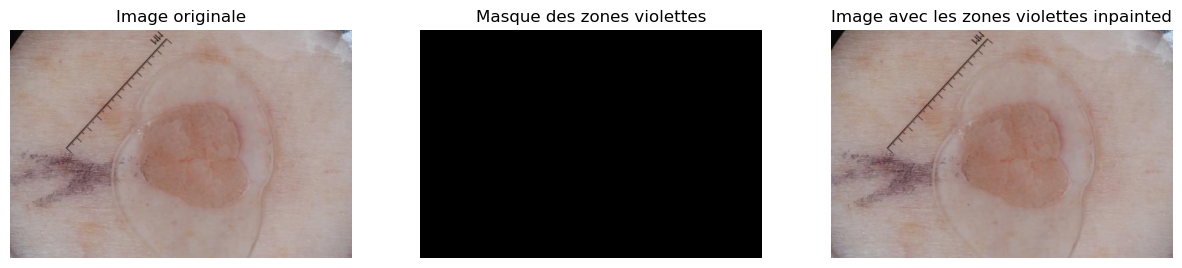

In [17]:
#Enlever lmes marques violttes

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import cv2

# Charger l'image
image = io.imread(images_train[2])

# Convertir l'image en espace de couleur HSV
hsv_image = color.rgb2hsv(image)

# Définir les plages de couleur violette dans l'espace HSV
lower_violet = np.array([130, 50, 50])  # Valeurs HSV minimales pour la couleur violette
upper_violet = np.array([170, 255, 255])  # Valeurs HSV maximales pour la couleur violette

# Seuillage de couleur pour détecter les zones violettes
violet_mask = np.all(hsv_image >= lower_violet, axis=-1) & np.all(hsv_image <= upper_violet, axis=-1)

# Appliquer l'inpainting pour remplir les zones violettes
inpainted_image = cv2.inpaint(image, violet_mask.astype(np.uint8), inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Afficher les résultats
plt.figure(figsize=(15, 5))

# Afficher l'image originale
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Image originale')
plt.axis('off')

# Afficher le masque des zones violettes
plt.subplot(1, 3, 2)
plt.imshow(violet_mask, cmap='gray')
plt.title('Masque des zones violettes')
plt.axis('off')

# Afficher l'image avec les zones violettes inpainted
plt.subplot(1, 3, 3)
plt.imshow(inpainted_image)
plt.title('Image avec les zones violettes inpainted')
plt.axis('off')

plt.show()


mask_state[0] = False
mask_state[1] = False
mask_state[2] = False
mask_state[3] = False
mask_state[4] = False
[False, False, False, False, False]  rule 1
[False, False, False, False, False]  rule 2
[False, False, False, False, False]  rule 4
[False, False, False, False, False]  rule 5
[False, False, False, False, False]
All mask rejected


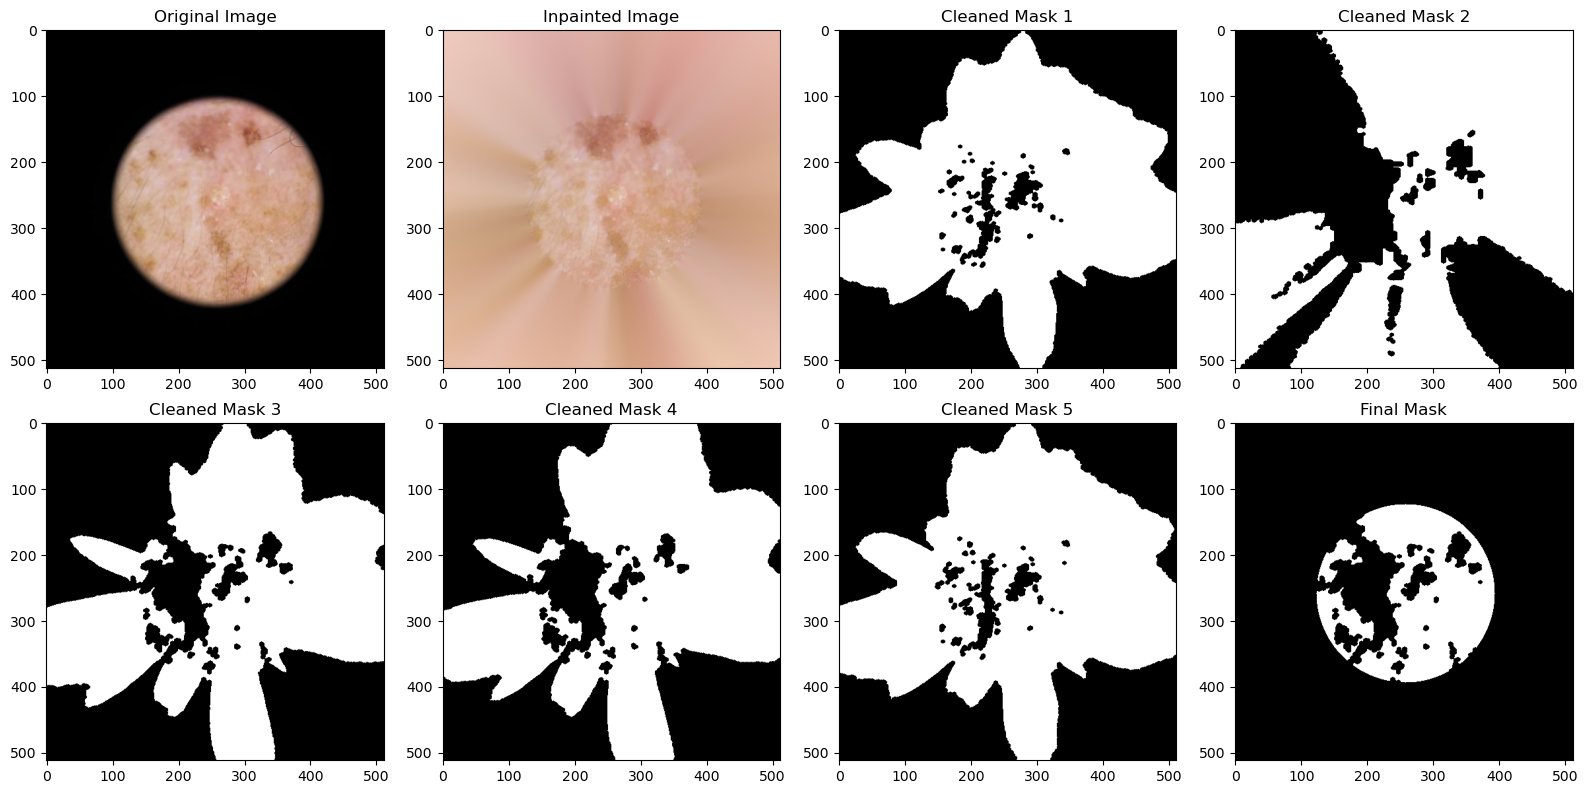

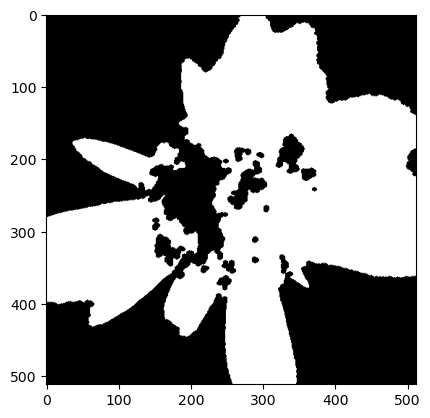

An error occurred in the dca, we return the image: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/shapedescr.cpp:201: error: (-215:Assertion failed) count >= 0 && (depth == CV_32F || depth == CV_32S) in function 'minEnclosingCircle'

mask_state[0] = False
mask_state[2] = False
mask_state[3] = False
mask_state[4] = False
[False, True, False, False, False]  rule 1
[False, True, False, False, False]  rule 2
[False, True, False, False, False]  rule 4
[False, True, False, False, False]  rule 5
[False, True, False, False, False]


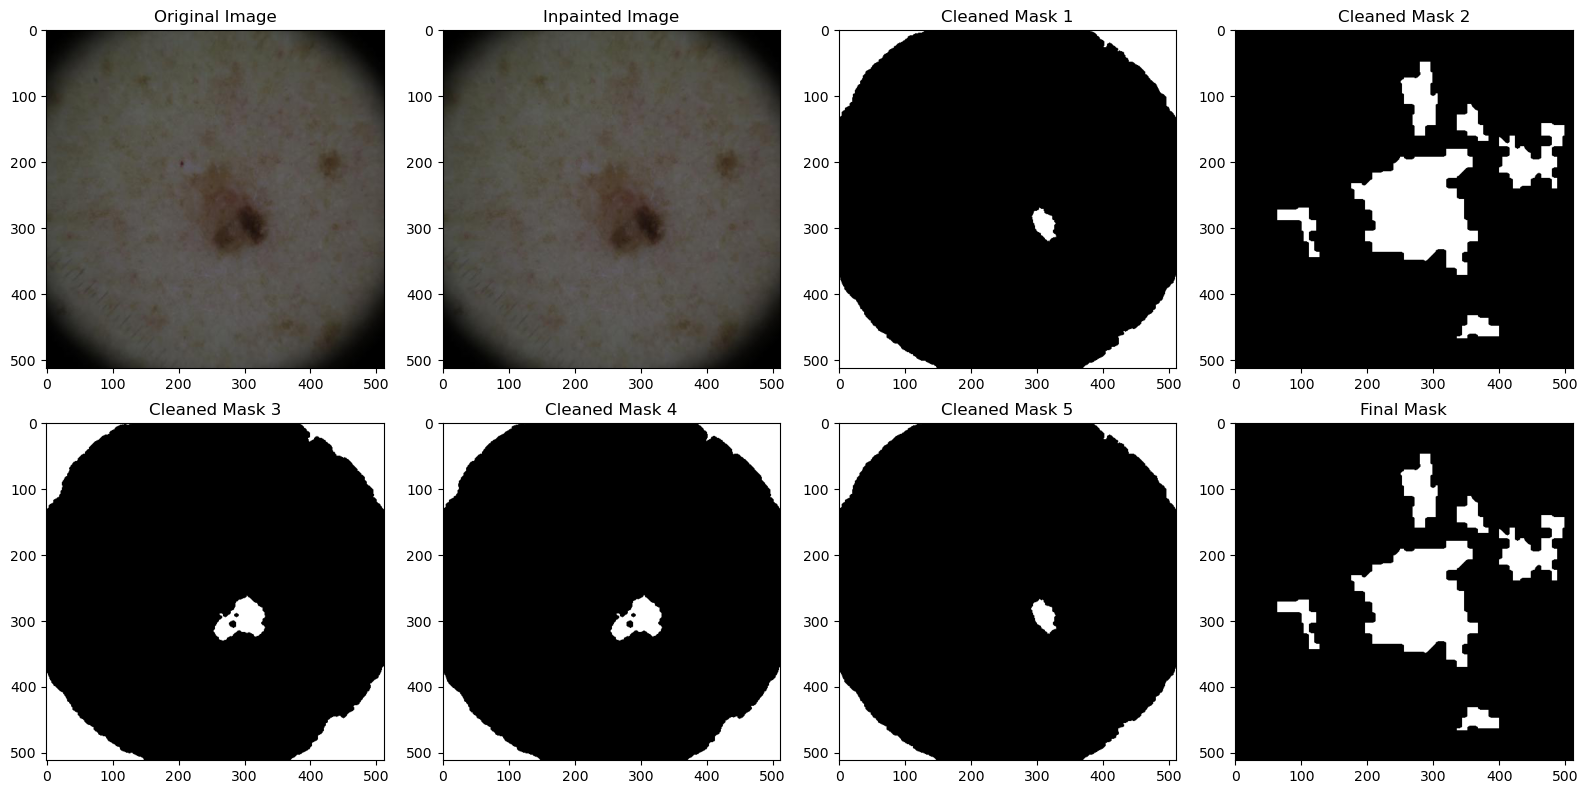

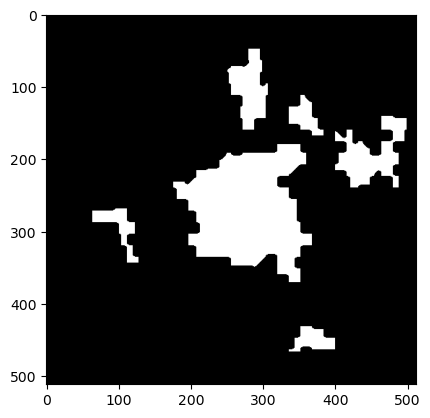

In [18]:
for image_path in images_test[1407:1409]:
    image = io.imread(image_path)
    image_cleaned = dr.dullrazor(image)
    image_cleaned_rgb = cv.cvtColor(image_cleaned, cv.COLOR_BGR2RGB)  # Convertir en RGB avant d'afficher
    inpainted_image,dca_mask = sp.inpainting_dca(image_cleaned_rgb)
    five_masks = five_segmentation(inpainted_image)    
    five_masks_cleaned = remove_small_parts_and_fill(five_masks)
    united_mask = union_mask(five_masks_cleaned)
    united_mask = np.array(united_mask, dtype=np.uint8)
    if dca_mask is not None:
        final_mask = postprocessing(united_mask, dca_mask)
    else:
        final_mask = united_mask
    final_mask_cleaned = remove_small_parts_and_fill([final_mask])[0]
    
    plt.figure(figsize=(16, 8))

    # Original image
    plt.subplot(2, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    # Inpainted image
    plt.subplot(2, 4, 2)
    plt.imshow(inpainted_image)
    plt.title('Inpainted Image')

    # 5 cleaned masks
    for j in range(5):
        plt.subplot(2, 4, j+3)
        plt.imshow(five_masks_cleaned[j], cmap='gray')
        plt.title(f'Cleaned Mask {j+1}')

    # Final mask
    plt.subplot(2, 4, 8)
    plt.imshow(final_mask_cleaned, cmap='gray')
    plt.title('Final Mask')

    plt.tight_layout()
    plt.show()

    plt.imshow(united_mask, cmap='gray')
    plt.show()

## Evaluation de la segmentation

(512, 512)


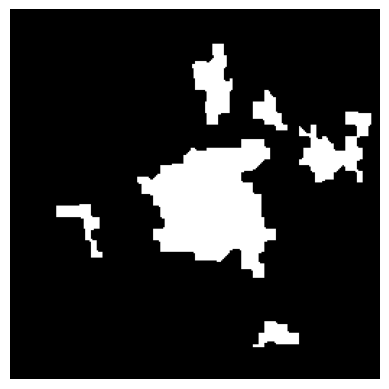

In [19]:

def resize_with_padding_binary_mask(mask, target_size):
    # Récupérer les dimensions du masque
    height, width = mask.shape[:2]

    # Calculer le ratio de redimensionnement en conservant la proportion
    if height > width:
        ratio = target_size[0] / height
    else:
        ratio = target_size[1] / width

    # Redimensionner le masque en conservant la proportion avec la méthode INTER_NEAREST
    resized_mask = cv.resize(mask, None, fx=ratio, fy=ratio, interpolation=cv.INTER_NEAREST)

    # Appliquer le padding pour obtenir une taille de 256x256
    pad_width = (target_size[1] - resized_mask.shape[1]) // 2
    pad_height = (target_size[0] - resized_mask.shape[0]) // 2
    padded_mask = cv.copyMakeBorder(resized_mask, pad_height, pad_height, pad_width, pad_width, cv.BORDER_CONSTANT, value=0)

    if padded_mask.shape[0] != target_size[0] or padded_mask.shape[1] != target_size[1]:
        padded_mask = cv.resize(padded_mask, target_size, interpolation=cv.INTER_NEAREST)
    return padded_mask


# Exemple d'utilisation
final_mask_cleaned = np.array(final_mask_cleaned).astype(int)
print(final_mask_cleaned.shape)

resized_padded_image = resize_with_padding_binary_mask(final_mask_cleaned, (256, 256))


plt.imshow(resized_padded_image, cmap='gray')
plt.axis('off')
plt.show()


Train/Train/ISIC_0014032.jpg


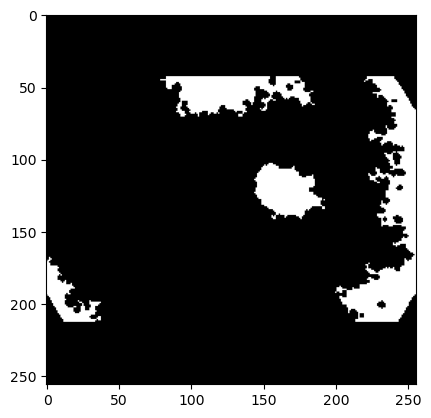

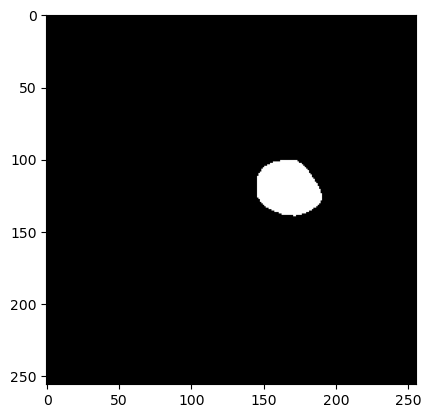

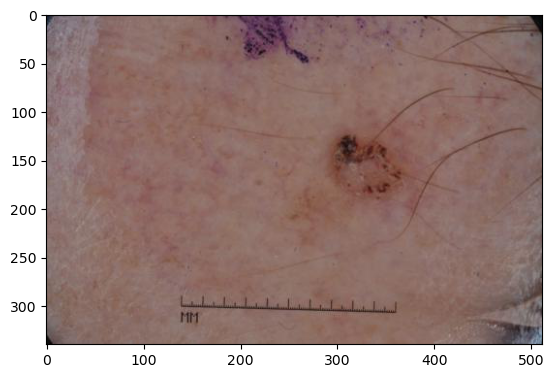

In [20]:
# Calculer le masque prédit
resultats = []
masks_pred_resized = []
image = io.imread(images_with_mask[0])
print(images_with_mask[0])
mask_pred = sp.compute_segmentation(images_with_mask[0])
mask_true = io.imread(mask_img_train[0])

mask_pred = mask_pred.astype(np.uint8)
mask_true = mask_true.astype(np.uint8)


mask_pred_resized = resize_with_padding_binary_mask(mask_pred, (256,256))
mask_true_resized = resize_with_padding_binary_mask(mask_true, (256,256))

#normaliser les masks
mask_pred_normalized = np.array(mask_pred_resized.astype(float) / mask_pred_resized.max()).astype(int)
mask_true_normalized = np.array(mask_true_resized.astype(float) / mask_true_resized.max()).astype(int)

dice = sp.dice_score(mask_pred_normalized,mask_true_normalized)
plt.imshow(mask_pred_resized,cmap='gray')
plt.show()
plt.imshow(mask_true_resized, cmap='gray')
plt.show()
plt.imshow(image)
plt.show()

# Ajouter les résultats à la liste
resultats.append({'nom_image': images_with_mask[i], 'dice_score': dice})

In [21]:
from tqdm import tqdm

resultats = []
masks_pred_resized = []
# Utilisation de tqdm pour afficher une barre de progression
for i in tqdm(range(0, len(images_with_mask))):
    image = io.imread(images_with_mask[i])
    mask_pred = sp.compute_segmentation(images_with_mask[i])
    mask_true = io.imread(mask_img_train[i])

    mask_pred = mask_pred.astype(np.uint8)
    mask_true = mask_true.astype(np.uint8)

    #normaliser les masks
    mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
    mask_true_normalized = np.array(mask_true.astype(float) / mask_true.max()).astype(int)

    dice = sp.dice_score(mask_pred_normalized,mask_true_normalized)
    # Ajouter les résultats à la liste
    masks_pred_resized.append(mask_pred_normalized)
    resultats.append({'nom_image': images_with_mask[i], 'dice_score': dice})

# Convertir la liste en DataFrame
df_resultats = pd.DataFrame(resultats)

# Afficher le DataFrame
print(df_resultats)



  1%|          | 17/1945 [00:04<08:35,  3.74it/s]/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/2220145600.py:15: RuntimeWarning: invalid value encountered in divide
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/2220145600.py:15: RuntimeWarning: invalid value encountered in cast
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
100%|██████████| 1945/1945 [06:25<00:00,  5.05it/s]

                         nom_image  dice_score
0     Train/Train/ISIC_0014032.jpg    0.271508
1     Train/Train/ISIC_0000067.jpg    0.938644
2     Train/Train/ISIC_0012406.jpg    0.874200
3     Train/Train/ISIC_0015440.jpg    0.740330
4     Train/Train/ISIC_0000077.jpg    0.697561
...                            ...         ...
1940  Train/Train/ISIC_0000366.jpg    0.577100
1941  Train/Train/ISIC_0014576.jpg    0.000000
1942  Train/Train/ISIC_0011228.jpg    0.884618
1943  Train/Train/ISIC_0002353.jpg    0.058844
1944  Train/Train/ISIC_0013458.jpg    0.847552

[1945 rows x 2 columns]


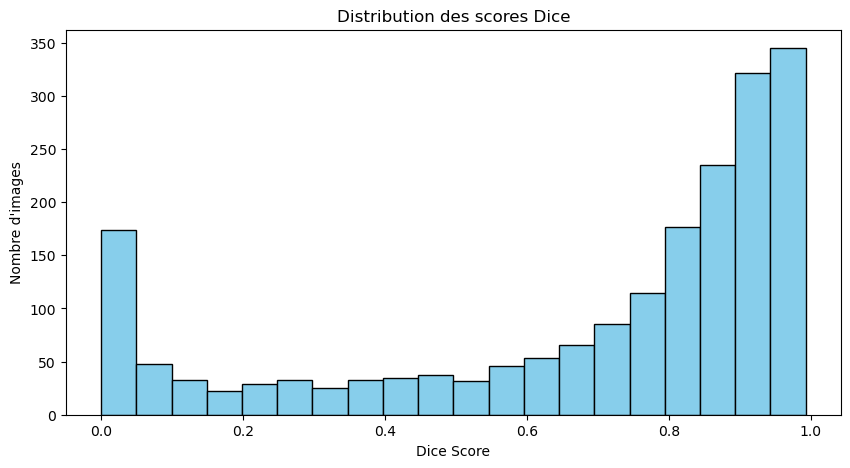

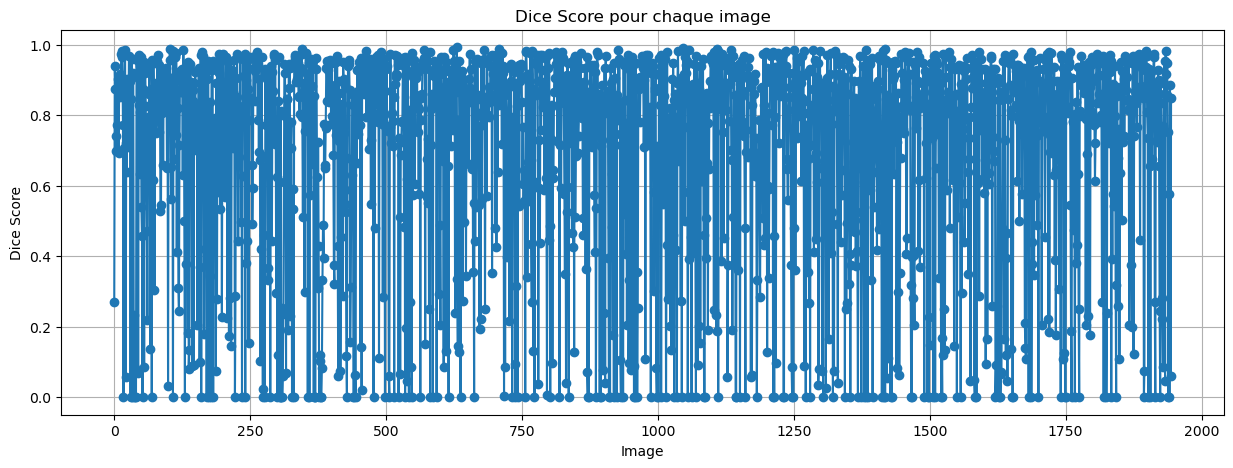

In [22]:
#Afficher les résulats sous forme de graphique
plt.figure(figsize=(10, 5))
plt.hist(df_resultats['dice_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Dice Score')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des scores Dice')
plt.show()

#tracer un graphique avec tous les disce score en ordonné et les images en absicess
plt.figure(figsize=(15, 5))
plt.plot(df_resultats['dice_score'], 'o-')
plt.xlabel('Image')
plt.ylabel('Dice Score')
plt.title('Dice Score pour chaque image')
plt.grid()
plt.show()



### Utiliser le masque de segmentation pour récupérer une image propre segmentée de la lésion

##### - Pour l'instant seulement sur les images qui ont un mask : images_with_masks

(384, 512)


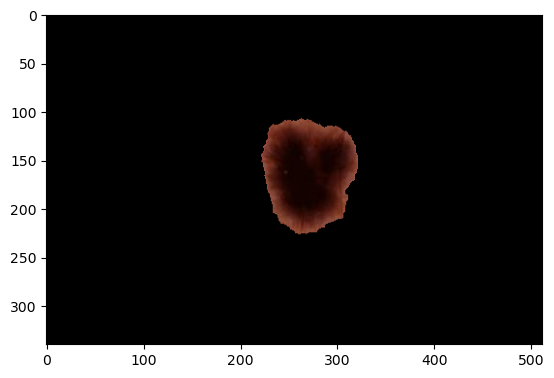

In [23]:
lesions_segmentees = []

print(masks_pred_resized[4].shape)

image= io.imread(images_with_mask[3])
mask_pred = masks_pred_resized[3]



lesions_r = image[:,:,0] * mask_pred
lesions_g = image[:,:,1] * mask_pred
lesions_b = image[:,:,2] * mask_pred

lesions = np.stack([lesions_r, lesions_g, lesions_b], axis=2)

plt.imshow(lesions)
plt.show()
#lesions_segmentees.append(lesions)


### Utiliser le masque de segmentation pour récupérer une image propre segmentée de la lésion

In [ ]:
segmented_lesions = []
for i in range(0, len(masks_pred_resized)):
    image= io.imread(images_with_mask[i])
    mask_pred = masks_pred_resized[i]
    lesions_r = image[:,:,0] * mask_pred
    lesions_g = image[:,:,1] * mask_pred
    lesions_b = image[:,:,2] * mask_pred
    lesions = np.stack([lesions_r, lesions_g, lesions_b], axis=2)
    segmented_lesions.append(lesions)
print(len(segmented_lesions))


### Resize l'image segmentée et appliquer le zero-padding pour avoir une image de taille 256x256

In [ ]:
segmented_lesions_square = []
for i in segmented_lesions:
    resized_padded_image = resize_with_padding_binary_mask(i, (256, 256))
    segmented_lesions_square.append(resized_padded_image)
print(len(segmented_lesions_square))


34


# CNN

### Préparation des données

- Images carrées de 256x256
- Normalisation des images
- Augmentation des données

In [28]:
# Création du set de données
def create_dataset(images_path, masks, output_dir):
    # Créer le répertoire de sortie s'il n'existe pas
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Parcourir les images et les masques
    for i, (image_path, mask) in enumerate(zip(images_path, masks)):
        mask = mask.astype(np.uint8)
        print(mask.shape)
        # Sauvegarder l'image et le masque final
        mask_name = os.path.basename(image_path) + '_pred_mask.png'
        io.imsave(os.path.join(output_dir, mask_name),mask )
        # Afficher la progression
        print(f'Processed {i+1}/{len(images_path)} images')


In [ ]:
create_dataset(images_with_mask, segmented_lesions_square, 'output_masks')

(256, 256, 3)
Processed 1/1945 images
(256, 256, 3)
Processed 2/1945 images
(256, 256, 3)
Processed 3/1945 images
(256, 256, 3)
Processed 4/1945 images
(256, 256, 3)
Processed 5/1945 images
(256, 256, 3)
Processed 6/1945 images
(256, 256, 3)
Processed 7/1945 images
(256, 256, 3)
Processed 8/1945 images
(256, 256, 3)
Processed 9/1945 images
(256, 256, 3)
Processed 10/1945 images
(256, 256, 3)
Processed 11/1945 images
(256, 256, 3)
Processed 12/1945 images
(256, 256, 3)
Processed 13/1945 images
(256, 256, 3)
Processed 14/1945 images
(256, 256, 3)
Processed 15/1945 images
(256, 256, 3)
Processed 16/1945 images
(256, 256, 3)
Processed 17/1945 images
(256, 256, 3)
Processed 18/1945 images
(256, 256, 3)
Processed 19/1945 images
(256, 256, 3)
Processed 20/1945 images
(256, 256, 3)
Processed 21/1945 images
(256, 256, 3)
Processed 22/1945 images
(256, 256, 3)
Processed 23/1945 images
(256, 256, 3)
Processed 24/1945 images
(256, 256, 3)
Processed 25/1945 images
(256, 256, 3)
Processed 26/1945 im

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_49967/560353820.py:13: UserWarning: output_masks/ISIC_0012406.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_49967/560353820.py:13: UserWarning: output_masks/ISIC_0014469.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_49967/560353820.py:13: UserWarning: output_masks/ISIC_0012770.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_49967/560353820.py:13: UserWarning: output_masks/ISIC_0014181.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


### Prepare data for CNN

In [ ]:
X_train = glob.glob('output_masks/*.png')
X_train_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_train]

# Get the names and classes as pandas Series
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(X_train_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(X_train_names)]

# Convert the pandas Series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()

X_train_ordered = []
X_train_ordered_names = []
for i in range(0, len(names_list)):
    for j in range(0, len(X_train_names)):
        if names_list[i] in X_train_names[j]:
            X_train_ordered.append(X_train[j])
            X_train_ordered_names.append(X_train_names[j])

##### Train test split

In [ ]:
X_train_petit = [io.imread(x) for x in X_train_ordered]
X_train_petit = np.array(X_train_petit)
y_train_petit = classes_list
y_train_petit = np.array(y_train_petit)

#Créer la validation set
from sklearn.model_selection import train_test_split

X_train_petit, X_val_petit, y_train_petit, y_val_petit = train_test_split(X_train_petit, y_train_petit, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Créer le modèle CNN
def create_cnn(input_shape, num_classes=8):
    model = models.Sequential()

    # Couche de convolution 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Couche de convolution 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Couche de convolution 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten les features en un vecteur
    model.add(layers.Flatten())

    # Couches fully connected
    model.add(layers.Dense(64, activation='relu'))

    # Couche de sortie
    model.add(layers.Dense(num_classes, activation='softmax'))  # softmax pour la classification multiclasse

    return model


# Définir la taille d'entrée
input_shape = (256, 256, 3)

# Créer le modèle CNN
model = create_cnn(input_shape)

# Afficher un résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Adapté à la classification avec plusieurs classes
              metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train_petit, y_train_petit, epochs=10, 
                    validation_data=(X_val_petit, y_val_petit))

# Affichage des courbes d'apprentissage
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Epoch 1/10
 9/49 [====>.........................] - ETA: 25s - loss: 43.2035 - accuracy: 0.5451

KeyboardInterrupt: 

## Préparation de la detection

In [ ]:
print(len(images_test))

6333


An error occurred in the dca, we return the image: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/shapedescr.cpp:201: error: (-215:Assertion failed) count >= 0 && (depth == CV_32F || depth == CV_32S) in function 'minEnclosingCircle'



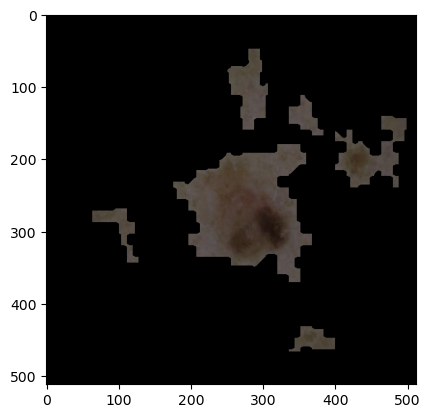

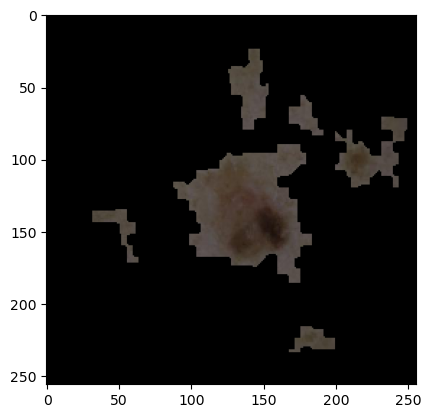

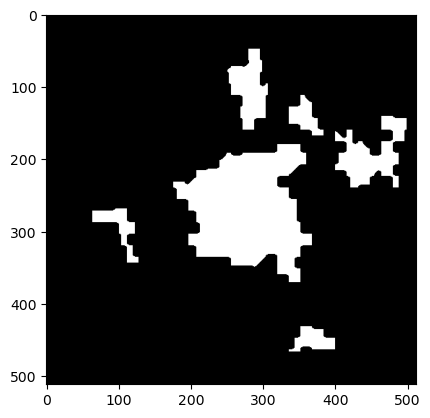

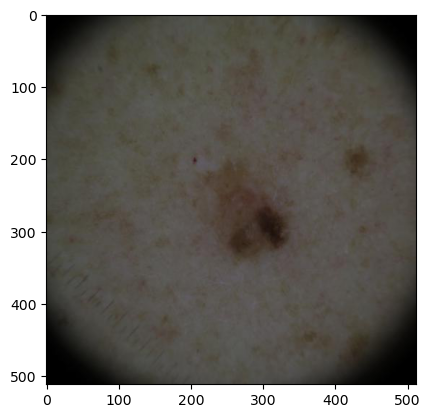

In [26]:
resultats = []
masks_pred_resized = []
segmented_lesions = []
segmented_lesions_square = []

image = io.imread(images_test[1408])
mask_pred = sp.compute_segmentation(images_test[1408])
#normaliser les masks
mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)

mask_pred = mask_pred_normalized
lesions_r = image[:,:,0] * mask_pred
lesions_g = image[:,:,1] * mask_pred
lesions_b = image[:,:,2] * mask_pred
lesions = np.stack([lesions_r, lesions_g, lesions_b], axis=2)
resized_padded_image = resize_with_padding_binary_mask(lesions, (256, 256))
segmented_lesions.append(lesions)
masks_pred_resized.append(mask_pred_normalized)
segmented_lesions_square.append(resized_padded_image)

plt.imshow(lesions)
plt.show()
plt.imshow(resized_padded_image)
plt.show()
plt.imshow(mask_pred_normalized, cmap='gray')
plt.show()
plt.imshow(image)
plt.show()

### Fonction pour calculer et enregistrer les images d'entrées du CNN (lésions segmentées)

In [ ]:
def compute_and_save_segmented_lesions(liste_chemins_images, output_dir):
    masks_pred_resized = []
    segmented_lesions = []
    segmented_lesions_square = []

    # Utilisation de tqdm pour afficher une barre de progression
    for i in tqdm(range(0, len(liste_chemins_images))):
        image = io.imread(liste_chemins_images[i])
        mask_pred = sp.compute_segmentation(liste_chemins_images[i])
        #normaliser les masks
        mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
        
        mask_pred = mask_pred_normalized
        lesions_r = image[:,:,0] * mask_pred
        lesions_g = image[:,:,1] * mask_pred
        lesions_b = image[:,:,2] * mask_pred
        lesions = np.stack([lesions_r, lesions_g, lesions_b], axis=2)
        resized_padded_image = resize_with_padding_binary_mask(lesions, (256, 256))
        segmented_lesions.append(lesions)
        masks_pred_resized.append(mask_pred_normalized)
        segmented_lesions_square.append(resized_padded_image)
    create_dataset(liste_chemins_images, segmented_lesions_square, output_dir)


In [27]:
resultats = []
masks_pred_resized = []
segmented_lesions = []
segmented_lesions_square = []

# Utilisation de tqdm pour afficher une barre de progression
for i in tqdm(range(0, len(images_test))):
    image = io.imread(images_test[i])
    mask_pred = sp.compute_segmentation(images_test[i])
    #normaliser les masks
    mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
    
    mask_pred = mask_pred_normalized
    lesions_r = image[:,:,0] * mask_pred
    lesions_g = image[:,:,1] * mask_pred
    lesions_b = image[:,:,2] * mask_pred
    lesions = np.stack([lesions_r, lesions_g, lesions_b], axis=2)
    resized_padded_image = resize_with_padding_binary_mask(lesions, (256, 256))
    segmented_lesions.append(lesions)
    masks_pred_resized.append(mask_pred_normalized)
    segmented_lesions_square.append(resized_padded_image)

  1%|          | 63/6333 [00:13<12:26,  8.40it/s]/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/2262402874.py:11: RuntimeWarning: invalid value encountered in divide
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/2262402874.py:11: RuntimeWarning: invalid value encountered in cast
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
 22%|██▏       | 1409/6333 [03:22<07:40, 10.69it/s]

An error occurred in the dca, we return the image: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/shapedescr.cpp:201: error: (-215:Assertion failed) count >= 0 && (depth == CV_32F || depth == CV_32S) in function 'minEnclosingCircle'



 28%|██▊       | 1803/6333 [04:18<31:27,  2.40it/s]

An error occurred in the dca, we return the image: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/shapedescr.cpp:201: error: (-215:Assertion failed) count >= 0 && (depth == CV_32F || depth == CV_32S) in function 'minEnclosingCircle'



 97%|█████████▋| 6166/6333 [13:50<00:13, 11.97it/s]

An error occurred in the dca, we return the image: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/drawing.cpp:1921: error: (-215:Assertion failed) radius >= 0 && thickness <= MAX_THICKNESS && 0 <= shift && shift <= XY_SHIFT in function 'circle'



100%|██████████| 6333/6333 [14:08<00:00,  7.47it/s]


NameError: name 'create_dataset' is not defined

In [29]:
create_dataset(images_test, segmented_lesions_square, 'output_masks_test_set')

(256, 256, 3)
Processed 1/6333 images
(256, 256, 3)
Processed 2/6333 images
(256, 256, 3)
Processed 3/6333 images
(256, 256, 3)
Processed 4/6333 images
(256, 256, 3)
Processed 5/6333 images
(256, 256, 3)
Processed 6/6333 images
(256, 256, 3)
Processed 7/6333 images
(256, 256, 3)
Processed 8/6333 images
(256, 256, 3)
Processed 9/6333 images
(256, 256, 3)
Processed 10/6333 images
(256, 256, 3)
Processed 11/6333 images
(256, 256, 3)
Processed 12/6333 images
(256, 256, 3)
Processed 13/6333 images
(256, 256, 3)
Processed 14/6333 images
(256, 256, 3)
Processed 15/6333 images
(256, 256, 3)
Processed 16/6333 images
(256, 256, 3)
Processed 17/6333 images
(256, 256, 3)
Processed 18/6333 images
(256, 256, 3)
Processed 19/6333 images
(256, 256, 3)
Processed 20/6333 images
(256, 256, 3)
Processed 21/6333 images
(256, 256, 3)
Processed 22/6333 images
(256, 256, 3)
Processed 23/6333 images
(256, 256, 3)
Processed 24/6333 images
(256, 256, 3)
Processed 25/6333 images
(256, 256, 3)
Processed 26/6333 im

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0029879.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0066820.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 85/6333 images
(256, 256, 3)
Processed 86/6333 images
(256, 256, 3)
Processed 87/6333 images
(256, 256, 3)
Processed 88/6333 images
(256, 256, 3)
Processed 89/6333 images
(256, 256, 3)
Processed 90/6333 images
(256, 256, 3)
Processed 91/6333 images
(256, 256, 3)
Processed 92/6333 images
(256, 256, 3)
Processed 93/6333 images
(256, 256, 3)
Processed 94/6333 images
(256, 256, 3)
Processed 95/6333 images
(256, 256, 3)
Processed 96/6333 images
(256, 256, 3)
Processed 97/6333 images
(256, 256, 3)
Processed 98/6333 images
(256, 256, 3)
Processed 99/6333 images
(256, 256, 3)
Processed 100/6333 images
(256, 256, 3)
Processed 101/6333 images
(256, 256, 3)
Processed 102/6333 images
(256, 256, 3)
Processed 103/6333 images
(256, 256, 3)
Processed 104/6333 images
(256, 256, 3)
Processed 105/6333 images
(256, 256, 3)
Processed 106/6333 images
(256, 256, 3)
Processed 107/6333 images
(256, 256, 3)
Processed 108/6333 images
(256, 256, 3)
Processed 109/6333 images
(256, 256, 3)
Processed 110/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0016054.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 290/6333 images
(256, 256, 3)
Processed 291/6333 images
(256, 256, 3)
Processed 292/6333 images
(256, 256, 3)
Processed 293/6333 images
(256, 256, 3)
Processed 294/6333 images
(256, 256, 3)
Processed 295/6333 images
(256, 256, 3)
Processed 296/6333 images
(256, 256, 3)
Processed 297/6333 images
(256, 256, 3)
Processed 298/6333 images
(256, 256, 3)
Processed 299/6333 images
(256, 256, 3)
Processed 300/6333 images
(256, 256, 3)
Processed 301/6333 images
(256, 256, 3)
Processed 302/6333 images
(256, 256, 3)
Processed 303/6333 images
(256, 256, 3)
Processed 304/6333 images
(256, 256, 3)
Processed 305/6333 images
(256, 256, 3)
Processed 306/6333 images
(256, 256, 3)
Processed 307/6333 images
(256, 256, 3)
Processed 308/6333 images
(256, 256, 3)
Processed 309/6333 images
(256, 256, 3)
Processed 310/6333 images
(256, 256, 3)
Processed 311/6333 images
(256, 256, 3)
Processed 312/6333 images
(256, 256, 3)
Processed 313/6333 images
(256, 256, 3)
Processed 314/6333 images
(256, 256, 3)


/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014286.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 528/6333 images
(256, 256, 3)
Processed 529/6333 images
(256, 256, 3)
Processed 530/6333 images
(256, 256, 3)
Processed 531/6333 images
(256, 256, 3)
Processed 532/6333 images
(256, 256, 3)
Processed 533/6333 images
(256, 256, 3)
Processed 534/6333 images
(256, 256, 3)
Processed 535/6333 images
(256, 256, 3)
Processed 536/6333 images
(256, 256, 3)
Processed 537/6333 images
(256, 256, 3)
Processed 538/6333 images
(256, 256, 3)
Processed 539/6333 images
(256, 256, 3)
Processed 540/6333 images
(256, 256, 3)
Processed 541/6333 images
(256, 256, 3)
Processed 542/6333 images
(256, 256, 3)
Processed 543/6333 images
(256, 256, 3)
Processed 544/6333 images
(256, 256, 3)
Processed 545/6333 images
(256, 256, 3)
Processed 546/6333 images
(256, 256, 3)
Processed 547/6333 images
(256, 256, 3)
Processed 548/6333 images
(256, 256, 3)
Processed 549/6333 images
(256, 256, 3)
Processed 550/6333 images
(256, 256, 3)
Processed 551/6333 images
(256, 256, 3)
Processed 552/6333 images
(256, 256, 3)


/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0067687.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 623/6333 images
(256, 256, 3)
Processed 624/6333 images
(256, 256, 3)
Processed 625/6333 images
(256, 256, 3)
Processed 626/6333 images
(256, 256, 3)
Processed 627/6333 images
(256, 256, 3)
Processed 628/6333 images
(256, 256, 3)
Processed 629/6333 images
(256, 256, 3)
Processed 630/6333 images
(256, 256, 3)
Processed 631/6333 images
(256, 256, 3)
Processed 632/6333 images
(256, 256, 3)
Processed 633/6333 images
(256, 256, 3)
Processed 634/6333 images
(256, 256, 3)
Processed 635/6333 images
(256, 256, 3)
Processed 636/6333 images
(256, 256, 3)
Processed 637/6333 images
(256, 256, 3)
Processed 638/6333 images
(256, 256, 3)
Processed 639/6333 images
(256, 256, 3)
Processed 640/6333 images
(256, 256, 3)
Processed 641/6333 images
(256, 256, 3)
Processed 642/6333 images
(256, 256, 3)
Processed 643/6333 images
(256, 256, 3)
Processed 644/6333 images
(256, 256, 3)
Processed 645/6333 images
(256, 256, 3)
Processed 646/6333 images
(256, 256, 3)
Processed 647/6333 images
(256, 256, 3)


/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0015984.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


(256, 256, 3)
Processed 759/6333 images
(256, 256, 3)
Processed 760/6333 images
(256, 256, 3)
Processed 761/6333 images
(256, 256, 3)
Processed 762/6333 images
(256, 256, 3)
Processed 763/6333 images
(256, 256, 3)
Processed 764/6333 images
(256, 256, 3)
Processed 765/6333 images
(256, 256, 3)
Processed 766/6333 images
(256, 256, 3)
Processed 767/6333 images
(256, 256, 3)
Processed 768/6333 images
(256, 256, 3)
Processed 769/6333 images
(256, 256, 3)
Processed 770/6333 images
(256, 256, 3)
Processed 771/6333 images
(256, 256, 3)
Processed 772/6333 images
(256, 256, 3)
Processed 773/6333 images
(256, 256, 3)
Processed 774/6333 images
(256, 256, 3)
Processed 775/6333 images
(256, 256, 3)
Processed 776/6333 images
(256, 256, 3)
Processed 777/6333 images
(256, 256, 3)
Processed 778/6333 images
(256, 256, 3)
Processed 779/6333 images
(256, 256, 3)
Processed 780/6333 images
(256, 256, 3)
Processed 781/6333 images
(256, 256, 3)
Processed 782/6333 images
(256, 256, 3)
Processed 783/6333 images


/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014522.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 816/6333 images
(256, 256, 3)
Processed 817/6333 images
(256, 256, 3)
Processed 818/6333 images
(256, 256, 3)
Processed 819/6333 images
(256, 256, 3)
Processed 820/6333 images
(256, 256, 3)
Processed 821/6333 images
(256, 256, 3)
Processed 822/6333 images
(256, 256, 3)
Processed 823/6333 images
(256, 256, 3)
Processed 824/6333 images
(256, 256, 3)
Processed 825/6333 images
(256, 256, 3)
Processed 826/6333 images
(256, 256, 3)
Processed 827/6333 images
(256, 256, 3)
Processed 828/6333 images
(256, 256, 3)
Processed 829/6333 images
(256, 256, 3)
Processed 830/6333 images
(256, 256, 3)
Processed 831/6333 images
(256, 256, 3)
Processed 832/6333 images
(256, 256, 3)
Processed 833/6333 images
(256, 256, 3)
Processed 834/6333 images
(256, 256, 3)
Processed 835/6333 images
(256, 256, 3)
Processed 836/6333 images
(256, 256, 3)
Processed 837/6333 images
(256, 256, 3)
Processed 838/6333 images
(256, 256, 3)
Processed 839/6333 images
(256, 256, 3)
Processed 840/6333 images
(256, 256, 3)


/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013670.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 1082/6333 images
(256, 256, 3)
Processed 1083/6333 images
(256, 256, 3)
Processed 1084/6333 images
(256, 256, 3)
Processed 1085/6333 images
(256, 256, 3)
Processed 1086/6333 images
(256, 256, 3)
Processed 1087/6333 images
(256, 256, 3)
Processed 1088/6333 images
(256, 256, 3)
Processed 1089/6333 images
(256, 256, 3)
Processed 1090/6333 images
(256, 256, 3)
Processed 1091/6333 images
(256, 256, 3)
Processed 1092/6333 images
(256, 256, 3)
Processed 1093/6333 images
(256, 256, 3)
Processed 1094/6333 images
(256, 256, 3)
Processed 1095/6333 images
(256, 256, 3)
Processed 1096/6333 images
(256, 256, 3)
Processed 1097/6333 images
(256, 256, 3)
Processed 1098/6333 images
(256, 256, 3)
Processed 1099/6333 images
(256, 256, 3)
Processed 1100/6333 images
(256, 256, 3)
Processed 1101/6333 images
(256, 256, 3)
Processed 1102/6333 images
(256, 256, 3)
Processed 1103/6333 images
(256, 256, 3)
Processed 1104/6333 images
(256, 256, 3)
Processed 1105/6333 images
(256, 256, 3)
Processed 1106/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0029920.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 1351/6333 images
(256, 256, 3)
Processed 1352/6333 images
(256, 256, 3)
Processed 1353/6333 images
(256, 256, 3)
Processed 1354/6333 images
(256, 256, 3)
Processed 1355/6333 images
(256, 256, 3)
Processed 1356/6333 images
(256, 256, 3)
Processed 1357/6333 images
(256, 256, 3)
Processed 1358/6333 images
(256, 256, 3)
Processed 1359/6333 images
(256, 256, 3)
Processed 1360/6333 images
(256, 256, 3)
Processed 1361/6333 images
(256, 256, 3)
Processed 1362/6333 images
(256, 256, 3)
Processed 1363/6333 images
(256, 256, 3)
Processed 1364/6333 images
(256, 256, 3)
Processed 1365/6333 images
(256, 256, 3)
Processed 1366/6333 images
(256, 256, 3)
Processed 1367/6333 images
(256, 256, 3)
Processed 1368/6333 images
(256, 256, 3)
Processed 1369/6333 images
(256, 256, 3)
Processed 1370/6333 images
(256, 256, 3)
Processed 1371/6333 images
(256, 256, 3)
Processed 1372/6333 images
(256, 256, 3)
Processed 1373/6333 images
(256, 256, 3)
Processed 1374/6333 images
(256, 256, 3)
Processed 1375/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0029288.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 1382/6333 images
(256, 256, 3)
Processed 1383/6333 images
(256, 256, 3)
Processed 1384/6333 images
(256, 256, 3)
Processed 1385/6333 images
(256, 256, 3)
Processed 1386/6333 images
(256, 256, 3)
Processed 1387/6333 images
(256, 256, 3)
Processed 1388/6333 images
(256, 256, 3)
Processed 1389/6333 images
(256, 256, 3)
Processed 1390/6333 images
(256, 256, 3)
Processed 1391/6333 images
(256, 256, 3)
Processed 1392/6333 images
(256, 256, 3)
Processed 1393/6333 images
(256, 256, 3)
Processed 1394/6333 images
(256, 256, 3)
Processed 1395/6333 images
(256, 256, 3)
Processed 1396/6333 images
(256, 256, 3)
Processed 1397/6333 images
(256, 256, 3)
Processed 1398/6333 images
(256, 256, 3)
Processed 1399/6333 images
(256, 256, 3)
Processed 1400/6333 images
(256, 256, 3)
Processed 1401/6333 images
(256, 256, 3)
Processed 1402/6333 images
(256, 256, 3)
Processed 1403/6333 images
(256, 256, 3)
Processed 1404/6333 images
(256, 256, 3)
Processed 1405/6333 images
(256, 256, 3)
Processed 1406/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0012126.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 1689/6333 images
(256, 256, 3)
Processed 1690/6333 images
(256, 256, 3)
Processed 1691/6333 images
(256, 256, 3)
Processed 1692/6333 images
(256, 256, 3)
Processed 1693/6333 images
(256, 256, 3)
Processed 1694/6333 images
(256, 256, 3)
Processed 1695/6333 images
(256, 256, 3)
Processed 1696/6333 images
(256, 256, 3)
Processed 1697/6333 images
(256, 256, 3)
Processed 1698/6333 images
(256, 256, 3)
Processed 1699/6333 images
(256, 256, 3)
Processed 1700/6333 images
(256, 256, 3)
Processed 1701/6333 images
(256, 256, 3)
Processed 1702/6333 images
(256, 256, 3)
Processed 1703/6333 images
(256, 256, 3)
Processed 1704/6333 images
(256, 256, 3)
Processed 1705/6333 images
(256, 256, 3)
Processed 1706/6333 images
(256, 256, 3)
Processed 1707/6333 images
(256, 256, 3)
Processed 1708/6333 images
(256, 256, 3)
Processed 1709/6333 images
(256, 256, 3)
Processed 1710/6333 images
(256, 256, 3)
Processed 1711/6333 images
(256, 256, 3)
Processed 1712/6333 images
(256, 256, 3)
Processed 1713/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0030741.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 1810/6333 images
(256, 256, 3)
Processed 1811/6333 images
(256, 256, 3)
Processed 1812/6333 images
(256, 256, 3)
Processed 1813/6333 images
(256, 256, 3)
Processed 1814/6333 images
(256, 256, 3)
Processed 1815/6333 images
(256, 256, 3)
Processed 1816/6333 images
(256, 256, 3)
Processed 1817/6333 images
(256, 256, 3)
Processed 1818/6333 images
(256, 256, 3)
Processed 1819/6333 images
(256, 256, 3)
Processed 1820/6333 images
(256, 256, 3)
Processed 1821/6333 images
(256, 256, 3)
Processed 1822/6333 images
(256, 256, 3)
Processed 1823/6333 images
(256, 256, 3)
Processed 1824/6333 images
(256, 256, 3)
Processed 1825/6333 images
(256, 256, 3)
Processed 1826/6333 images
(256, 256, 3)
Processed 1827/6333 images
(256, 256, 3)
Processed 1828/6333 images
(256, 256, 3)
Processed 1829/6333 images
(256, 256, 3)
Processed 1830/6333 images
(256, 256, 3)
Processed 1831/6333 images
(256, 256, 3)
Processed 1832/6333 images
(256, 256, 3)
Processed 1833/6333 images
(256, 256, 3)
Processed 1834/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0008396.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0027361.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 1937/6333 images
(256, 256, 3)
Processed 1938/6333 images
(256, 256, 3)
Processed 1939/6333 images
(256, 256, 3)
Processed 1940/6333 images
(256, 256, 3)
Processed 1941/6333 images
(256, 256, 3)
Processed 1942/6333 images
(256, 256, 3)
Processed 1943/6333 images
(256, 256, 3)
Processed 1944/6333 images
(256, 256, 3)
Processed 1945/6333 images
(256, 256, 3)
Processed 1946/6333 images
(256, 256, 3)
Processed 1947/6333 images
(256, 256, 3)
Processed 1948/6333 images
(256, 256, 3)
Processed 1949/6333 images
(256, 256, 3)
Processed 1950/6333 images
(256, 256, 3)
Processed 1951/6333 images
(256, 256, 3)
Processed 1952/6333 images
(256, 256, 3)
Processed 1953/6333 images
(256, 256, 3)
Processed 1954/6333 images
(256, 256, 3)
Processed 1955/6333 images
(256, 256, 3)
Processed 1956/6333 images
(256, 256, 3)
Processed 1957/6333 images
(256, 256, 3)
Processed 1958/6333 images
(256, 256, 3)
Processed 1959/6333 images
(256, 256, 3)
Processed 1960/6333 images
(256, 256, 3)
Processed 1961/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0059468.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2061/6333 images
(256, 256, 3)
Processed 2062/6333 images
(256, 256, 3)
Processed 2063/6333 images
(256, 256, 3)
Processed 2064/6333 images
(256, 256, 3)
Processed 2065/6333 images
(256, 256, 3)
Processed 2066/6333 images
(256, 256, 3)
Processed 2067/6333 images
(256, 256, 3)
Processed 2068/6333 images
(256, 256, 3)
Processed 2069/6333 images
(256, 256, 3)
Processed 2070/6333 images
(256, 256, 3)
Processed 2071/6333 images
(256, 256, 3)
Processed 2072/6333 images
(256, 256, 3)
Processed 2073/6333 images
(256, 256, 3)
Processed 2074/6333 images
(256, 256, 3)
Processed 2075/6333 images
(256, 256, 3)
Processed 2076/6333 images
(256, 256, 3)
Processed 2077/6333 images
(256, 256, 3)
Processed 2078/6333 images
(256, 256, 3)
Processed 2079/6333 images
(256, 256, 3)
Processed 2080/6333 images
(256, 256, 3)
Processed 2081/6333 images
(256, 256, 3)
Processed 2082/6333 images
(256, 256, 3)
Processed 2083/6333 images
(256, 256, 3)
Processed 2084/6333 images
(256, 256, 3)
Processed 2085/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0069622.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2179/6333 images
(256, 256, 3)
Processed 2180/6333 images
(256, 256, 3)
Processed 2181/6333 images
(256, 256, 3)
Processed 2182/6333 images
(256, 256, 3)
Processed 2183/6333 images
(256, 256, 3)
Processed 2184/6333 images
(256, 256, 3)
Processed 2185/6333 images
(256, 256, 3)
Processed 2186/6333 images
(256, 256, 3)
Processed 2187/6333 images
(256, 256, 3)
Processed 2188/6333 images
(256, 256, 3)
Processed 2189/6333 images
(256, 256, 3)
Processed 2190/6333 images
(256, 256, 3)
Processed 2191/6333 images
(256, 256, 3)
Processed 2192/6333 images
(256, 256, 3)
Processed 2193/6333 images
(256, 256, 3)
Processed 2194/6333 images
(256, 256, 3)
Processed 2195/6333 images
(256, 256, 3)
Processed 2196/6333 images
(256, 256, 3)
Processed 2197/6333 images
(256, 256, 3)
Processed 2198/6333 images
(256, 256, 3)
Processed 2199/6333 images
(256, 256, 3)
Processed 2200/6333 images
(256, 256, 3)
Processed 2201/6333 images
(256, 256, 3)
Processed 2202/6333 images
(256, 256, 3)
Processed 2203/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014179.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013164.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2240/6333 images
(256, 256, 3)
Processed 2241/6333 images
(256, 256, 3)
Processed 2242/6333 images
(256, 256, 3)
Processed 2243/6333 images
(256, 256, 3)
Processed 2244/6333 images
(256, 256, 3)
Processed 2245/6333 images
(256, 256, 3)
Processed 2246/6333 images
(256, 256, 3)
Processed 2247/6333 images
(256, 256, 3)
Processed 2248/6333 images
(256, 256, 3)
Processed 2249/6333 images
(256, 256, 3)
Processed 2250/6333 images
(256, 256, 3)
Processed 2251/6333 images
(256, 256, 3)
Processed 2252/6333 images
(256, 256, 3)
Processed 2253/6333 images
(256, 256, 3)
Processed 2254/6333 images
(256, 256, 3)
Processed 2255/6333 images
(256, 256, 3)
Processed 2256/6333 images
(256, 256, 3)
Processed 2257/6333 images
(256, 256, 3)
Processed 2258/6333 images
(256, 256, 3)
Processed 2259/6333 images
(256, 256, 3)
Processed 2260/6333 images
(256, 256, 3)
Processed 2261/6333 images
(256, 256, 3)
Processed 2262/6333 images
(256, 256, 3)
Processed 2263/6333 images
(256, 256, 3)
Processed 2264/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0012722.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2297/6333 images
(256, 256, 3)
Processed 2298/6333 images
(256, 256, 3)
Processed 2299/6333 images
(256, 256, 3)
Processed 2300/6333 images
(256, 256, 3)
Processed 2301/6333 images
(256, 256, 3)
Processed 2302/6333 images
(256, 256, 3)
Processed 2303/6333 images
(256, 256, 3)
Processed 2304/6333 images
(256, 256, 3)
Processed 2305/6333 images
(256, 256, 3)
Processed 2306/6333 images
(256, 256, 3)
Processed 2307/6333 images
(256, 256, 3)
Processed 2308/6333 images
(256, 256, 3)
Processed 2309/6333 images
(256, 256, 3)
Processed 2310/6333 images
(256, 256, 3)
Processed 2311/6333 images
(256, 256, 3)
Processed 2312/6333 images
(256, 256, 3)
Processed 2313/6333 images
(256, 256, 3)
Processed 2314/6333 images
(256, 256, 3)
Processed 2315/6333 images
(256, 256, 3)
Processed 2316/6333 images
(256, 256, 3)
Processed 2317/6333 images
(256, 256, 3)
Processed 2318/6333 images
(256, 256, 3)
Processed 2319/6333 images
(256, 256, 3)
Processed 2320/6333 images
(256, 256, 3)
Processed 2321/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014031.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2415/6333 images
(256, 256, 3)
Processed 2416/6333 images
(256, 256, 3)
Processed 2417/6333 images
(256, 256, 3)
Processed 2418/6333 images
(256, 256, 3)
Processed 2419/6333 images
(256, 256, 3)
Processed 2420/6333 images
(256, 256, 3)
Processed 2421/6333 images
(256, 256, 3)
Processed 2422/6333 images
(256, 256, 3)
Processed 2423/6333 images
(256, 256, 3)
Processed 2424/6333 images
(256, 256, 3)
Processed 2425/6333 images
(256, 256, 3)
Processed 2426/6333 images
(256, 256, 3)
Processed 2427/6333 images
(256, 256, 3)
Processed 2428/6333 images
(256, 256, 3)
Processed 2429/6333 images
(256, 256, 3)
Processed 2430/6333 images
(256, 256, 3)
Processed 2431/6333 images
(256, 256, 3)
Processed 2432/6333 images
(256, 256, 3)
Processed 2433/6333 images
(256, 256, 3)
Processed 2434/6333 images
(256, 256, 3)
Processed 2435/6333 images
(256, 256, 3)
Processed 2436/6333 images
(256, 256, 3)
Processed 2437/6333 images
(256, 256, 3)
Processed 2438/6333 images
(256, 256, 3)
Processed 2439/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014790.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2475/6333 images
(256, 256, 3)
Processed 2476/6333 images
(256, 256, 3)
Processed 2477/6333 images
(256, 256, 3)
Processed 2478/6333 images
(256, 256, 3)
Processed 2479/6333 images
(256, 256, 3)
Processed 2480/6333 images
(256, 256, 3)
Processed 2481/6333 images
(256, 256, 3)
Processed 2482/6333 images
(256, 256, 3)
Processed 2483/6333 images
(256, 256, 3)
Processed 2484/6333 images
(256, 256, 3)
Processed 2485/6333 images
(256, 256, 3)
Processed 2486/6333 images
(256, 256, 3)
Processed 2487/6333 images
(256, 256, 3)
Processed 2488/6333 images
(256, 256, 3)
Processed 2489/6333 images
(256, 256, 3)
Processed 2490/6333 images
(256, 256, 3)
Processed 2491/6333 images
(256, 256, 3)
Processed 2492/6333 images
(256, 256, 3)
Processed 2493/6333 images
(256, 256, 3)
Processed 2494/6333 images
(256, 256, 3)
Processed 2495/6333 images
(256, 256, 3)
Processed 2496/6333 images
(256, 256, 3)
Processed 2497/6333 images
(256, 256, 3)
Processed 2498/6333 images
(256, 256, 3)
Processed 2499/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013808.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2628/6333 images
(256, 256, 3)
Processed 2629/6333 images
(256, 256, 3)
Processed 2630/6333 images
(256, 256, 3)
Processed 2631/6333 images
(256, 256, 3)
Processed 2632/6333 images
(256, 256, 3)
Processed 2633/6333 images
(256, 256, 3)
Processed 2634/6333 images
(256, 256, 3)
Processed 2635/6333 images
(256, 256, 3)
Processed 2636/6333 images
(256, 256, 3)
Processed 2637/6333 images
(256, 256, 3)
Processed 2638/6333 images
(256, 256, 3)
Processed 2639/6333 images
(256, 256, 3)
Processed 2640/6333 images
(256, 256, 3)
Processed 2641/6333 images
(256, 256, 3)
Processed 2642/6333 images
(256, 256, 3)
Processed 2643/6333 images
(256, 256, 3)
Processed 2644/6333 images
(256, 256, 3)
Processed 2645/6333 images
(256, 256, 3)
Processed 2646/6333 images
(256, 256, 3)
Processed 2647/6333 images
(256, 256, 3)
Processed 2648/6333 images
(256, 256, 3)
Processed 2649/6333 images
(256, 256, 3)
Processed 2650/6333 images
(256, 256, 3)
Processed 2651/6333 images
(256, 256, 3)
Processed 2652/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0068048.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 2691/6333 images
(256, 256, 3)
Processed 2692/6333 images
(256, 256, 3)
Processed 2693/6333 images
(256, 256, 3)
Processed 2694/6333 images
(256, 256, 3)
Processed 2695/6333 images
(256, 256, 3)
Processed 2696/6333 images
(256, 256, 3)
Processed 2697/6333 images
(256, 256, 3)
Processed 2698/6333 images
(256, 256, 3)
Processed 2699/6333 images
(256, 256, 3)
Processed 2700/6333 images
(256, 256, 3)
Processed 2701/6333 images
(256, 256, 3)
Processed 2702/6333 images
(256, 256, 3)
Processed 2703/6333 images
(256, 256, 3)
Processed 2704/6333 images
(256, 256, 3)
Processed 2705/6333 images
(256, 256, 3)
Processed 2706/6333 images
(256, 256, 3)
Processed 2707/6333 images
(256, 256, 3)
Processed 2708/6333 images
(256, 256, 3)
Processed 2709/6333 images
(256, 256, 3)
Processed 2710/6333 images
(256, 256, 3)
Processed 2711/6333 images
(256, 256, 3)
Processed 2712/6333 images
(256, 256, 3)
Processed 2713/6333 images
(256, 256, 3)
Processed 2714/6333 images
(256, 256, 3)
Processed 2715/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013599.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 3083/6333 images
(256, 256, 3)
Processed 3084/6333 images
(256, 256, 3)
Processed 3085/6333 images
(256, 256, 3)
Processed 3086/6333 images
(256, 256, 3)
Processed 3087/6333 images
(256, 256, 3)
Processed 3088/6333 images
(256, 256, 3)
Processed 3089/6333 images
(256, 256, 3)
Processed 3090/6333 images
(256, 256, 3)
Processed 3091/6333 images
(256, 256, 3)
Processed 3092/6333 images
(256, 256, 3)
Processed 3093/6333 images
(256, 256, 3)
Processed 3094/6333 images
(256, 256, 3)
Processed 3095/6333 images
(256, 256, 3)
Processed 3096/6333 images
(256, 256, 3)
Processed 3097/6333 images
(256, 256, 3)
Processed 3098/6333 images
(256, 256, 3)
Processed 3099/6333 images
(256, 256, 3)
Processed 3100/6333 images
(256, 256, 3)
Processed 3101/6333 images
(256, 256, 3)
Processed 3102/6333 images
(256, 256, 3)
Processed 3103/6333 images
(256, 256, 3)
Processed 3104/6333 images
(256, 256, 3)
Processed 3105/6333 images
(256, 256, 3)
Processed 3106/6333 images
(256, 256, 3)
Processed 3107/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0061696.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 3126/6333 images
(256, 256, 3)
Processed 3127/6333 images
(256, 256, 3)
Processed 3128/6333 images
(256, 256, 3)
Processed 3129/6333 images
(256, 256, 3)
Processed 3130/6333 images
(256, 256, 3)
Processed 3131/6333 images
(256, 256, 3)
Processed 3132/6333 images
(256, 256, 3)
Processed 3133/6333 images
(256, 256, 3)
Processed 3134/6333 images
(256, 256, 3)
Processed 3135/6333 images
(256, 256, 3)
Processed 3136/6333 images
(256, 256, 3)
Processed 3137/6333 images
(256, 256, 3)
Processed 3138/6333 images
(256, 256, 3)
Processed 3139/6333 images
(256, 256, 3)
Processed 3140/6333 images
(256, 256, 3)
Processed 3141/6333 images
(256, 256, 3)
Processed 3142/6333 images
(256, 256, 3)


/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0012452.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 3143/6333 images
(256, 256, 3)
Processed 3144/6333 images
(256, 256, 3)
Processed 3145/6333 images
(256, 256, 3)
Processed 3146/6333 images
(256, 256, 3)
Processed 3147/6333 images
(256, 256, 3)
Processed 3148/6333 images
(256, 256, 3)
Processed 3149/6333 images
(256, 256, 3)
Processed 3150/6333 images
(256, 256, 3)
Processed 3151/6333 images
(256, 256, 3)
Processed 3152/6333 images
(256, 256, 3)
Processed 3153/6333 images
(256, 256, 3)
Processed 3154/6333 images
(256, 256, 3)
Processed 3155/6333 images
(256, 256, 3)
Processed 3156/6333 images
(256, 256, 3)
Processed 3157/6333 images
(256, 256, 3)
Processed 3158/6333 images
(256, 256, 3)
Processed 3159/6333 images
(256, 256, 3)
Processed 3160/6333 images
(256, 256, 3)
Processed 3161/6333 images
(256, 256, 3)
Processed 3162/6333 images
(256, 256, 3)
Processed 3163/6333 images
(256, 256, 3)
Processed 3164/6333 images
(256, 256, 3)
Processed 3165/6333 images
(256, 256, 3)
Processed 3166/6333 images
(256, 256, 3)
Processed 3167/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013966.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0000098.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


(256, 256, 3)
Processed 3183/6333 images
(256, 256, 3)
Processed 3184/6333 images
(256, 256, 3)
Processed 3185/6333 images
(256, 256, 3)
Processed 3186/6333 images
(256, 256, 3)
Processed 3187/6333 images
(256, 256, 3)
Processed 3188/6333 images
(256, 256, 3)
Processed 3189/6333 images
(256, 256, 3)
Processed 3190/6333 images
(256, 256, 3)
Processed 3191/6333 images
(256, 256, 3)
Processed 3192/6333 images
(256, 256, 3)
Processed 3193/6333 images
(256, 256, 3)
Processed 3194/6333 images
(256, 256, 3)
Processed 3195/6333 images
(256, 256, 3)
Processed 3196/6333 images
(256, 256, 3)
Processed 3197/6333 images
(256, 256, 3)
Processed 3198/6333 images
(256, 256, 3)
Processed 3199/6333 images
(256, 256, 3)
Processed 3200/6333 images
(256, 256, 3)
Processed 3201/6333 images
(256, 256, 3)
Processed 3202/6333 images
(256, 256, 3)
Processed 3203/6333 images
(256, 256, 3)


/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0033877.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 3204/6333 images
(256, 256, 3)
Processed 3205/6333 images
(256, 256, 3)
Processed 3206/6333 images
(256, 256, 3)
Processed 3207/6333 images
(256, 256, 3)
Processed 3208/6333 images
(256, 256, 3)
Processed 3209/6333 images
(256, 256, 3)
Processed 3210/6333 images
(256, 256, 3)
Processed 3211/6333 images
(256, 256, 3)
Processed 3212/6333 images
(256, 256, 3)
Processed 3213/6333 images
(256, 256, 3)
Processed 3214/6333 images
(256, 256, 3)
Processed 3215/6333 images
(256, 256, 3)
Processed 3216/6333 images
(256, 256, 3)
Processed 3217/6333 images
(256, 256, 3)
Processed 3218/6333 images
(256, 256, 3)
Processed 3219/6333 images
(256, 256, 3)
Processed 3220/6333 images
(256, 256, 3)
Processed 3221/6333 images
(256, 256, 3)
Processed 3222/6333 images
(256, 256, 3)
Processed 3223/6333 images
(256, 256, 3)
Processed 3224/6333 images
(256, 256, 3)
Processed 3225/6333 images
(256, 256, 3)
Processed 3226/6333 images
(256, 256, 3)
Processed 3227/6333 images
(256, 256, 3)
Processed 3228/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0015938.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 3682/6333 images
(256, 256, 3)
Processed 3683/6333 images
(256, 256, 3)
Processed 3684/6333 images
(256, 256, 3)
Processed 3685/6333 images
(256, 256, 3)
Processed 3686/6333 images
(256, 256, 3)
Processed 3687/6333 images
(256, 256, 3)
Processed 3688/6333 images
(256, 256, 3)
Processed 3689/6333 images
(256, 256, 3)
Processed 3690/6333 images
(256, 256, 3)
Processed 3691/6333 images
(256, 256, 3)
Processed 3692/6333 images
(256, 256, 3)
Processed 3693/6333 images
(256, 256, 3)
Processed 3694/6333 images
(256, 256, 3)
Processed 3695/6333 images
(256, 256, 3)
Processed 3696/6333 images
(256, 256, 3)
Processed 3697/6333 images
(256, 256, 3)
Processed 3698/6333 images
(256, 256, 3)
Processed 3699/6333 images
(256, 256, 3)
Processed 3700/6333 images
(256, 256, 3)
Processed 3701/6333 images
(256, 256, 3)
Processed 3702/6333 images
(256, 256, 3)
Processed 3703/6333 images
(256, 256, 3)
Processed 3704/6333 images
(256, 256, 3)
Processed 3705/6333 images
(256, 256, 3)
Processed 3706/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0067160.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 3738/6333 images
(256, 256, 3)
Processed 3739/6333 images
(256, 256, 3)
Processed 3740/6333 images
(256, 256, 3)
Processed 3741/6333 images
(256, 256, 3)
Processed 3742/6333 images
(256, 256, 3)
Processed 3743/6333 images
(256, 256, 3)
Processed 3744/6333 images
(256, 256, 3)
Processed 3745/6333 images
(256, 256, 3)
Processed 3746/6333 images
(256, 256, 3)
Processed 3747/6333 images
(256, 256, 3)
Processed 3748/6333 images
(256, 256, 3)
Processed 3749/6333 images
(256, 256, 3)
Processed 3750/6333 images
(256, 256, 3)
Processed 3751/6333 images
(256, 256, 3)
Processed 3752/6333 images
(256, 256, 3)
Processed 3753/6333 images
(256, 256, 3)
Processed 3754/6333 images
(256, 256, 3)
Processed 3755/6333 images
(256, 256, 3)
Processed 3756/6333 images
(256, 256, 3)
Processed 3757/6333 images
(256, 256, 3)
Processed 3758/6333 images
(256, 256, 3)
Processed 3759/6333 images
(256, 256, 3)
Processed 3760/6333 images
(256, 256, 3)
Processed 3761/6333 images
(256, 256, 3)
Processed 3762/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014372.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 3850/6333 images
(256, 256, 3)
Processed 3851/6333 images
(256, 256, 3)
Processed 3852/6333 images
(256, 256, 3)
Processed 3853/6333 images
(256, 256, 3)
Processed 3854/6333 images
(256, 256, 3)
Processed 3855/6333 images
(256, 256, 3)
Processed 3856/6333 images
(256, 256, 3)
Processed 3857/6333 images
(256, 256, 3)
Processed 3858/6333 images
(256, 256, 3)
Processed 3859/6333 images
(256, 256, 3)
Processed 3860/6333 images
(256, 256, 3)
Processed 3861/6333 images
(256, 256, 3)
Processed 3862/6333 images
(256, 256, 3)
Processed 3863/6333 images
(256, 256, 3)
Processed 3864/6333 images
(256, 256, 3)
Processed 3865/6333 images
(256, 256, 3)
Processed 3866/6333 images
(256, 256, 3)
Processed 3867/6333 images
(256, 256, 3)
Processed 3868/6333 images
(256, 256, 3)
Processed 3869/6333 images
(256, 256, 3)
Processed 3870/6333 images
(256, 256, 3)
Processed 3871/6333 images
(256, 256, 3)
Processed 3872/6333 images
(256, 256, 3)
Processed 3873/6333 images
(256, 256, 3)
Processed 3874/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013592.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4027/6333 images
(256, 256, 3)
Processed 4028/6333 images
(256, 256, 3)
Processed 4029/6333 images
(256, 256, 3)
Processed 4030/6333 images
(256, 256, 3)
Processed 4031/6333 images
(256, 256, 3)
Processed 4032/6333 images
(256, 256, 3)
Processed 4033/6333 images
(256, 256, 3)
Processed 4034/6333 images
(256, 256, 3)
Processed 4035/6333 images
(256, 256, 3)
Processed 4036/6333 images
(256, 256, 3)
Processed 4037/6333 images
(256, 256, 3)
Processed 4038/6333 images
(256, 256, 3)
Processed 4039/6333 images
(256, 256, 3)
Processed 4040/6333 images
(256, 256, 3)
Processed 4041/6333 images
(256, 256, 3)
Processed 4042/6333 images
(256, 256, 3)
Processed 4043/6333 images
(256, 256, 3)
Processed 4044/6333 images
(256, 256, 3)
Processed 4045/6333 images
(256, 256, 3)
Processed 4046/6333 images
(256, 256, 3)
Processed 4047/6333 images
(256, 256, 3)
Processed 4048/6333 images
(256, 256, 3)
Processed 4049/6333 images
(256, 256, 3)
Processed 4050/6333 images
(256, 256, 3)
Processed 4051/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0064108.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0029020.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0030954.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4087/6333 images
(256, 256, 3)
Processed 4088/6333 images
(256, 256, 3)
Processed 4089/6333 images
(256, 256, 3)
Processed 4090/6333 images
(256, 256, 3)
Processed 4091/6333 images
(256, 256, 3)
Processed 4092/6333 images
(256, 256, 3)
Processed 4093/6333 images
(256, 256, 3)
Processed 4094/6333 images
(256, 256, 3)
Processed 4095/6333 images
(256, 256, 3)
Processed 4096/6333 images
(256, 256, 3)
Processed 4097/6333 images
(256, 256, 3)
Processed 4098/6333 images
(256, 256, 3)
Processed 4099/6333 images
(256, 256, 3)
Processed 4100/6333 images
(256, 256, 3)
Processed 4101/6333 images
(256, 256, 3)
Processed 4102/6333 images
(256, 256, 3)
Processed 4103/6333 images
(256, 256, 3)
Processed 4104/6333 images
(256, 256, 3)
Processed 4105/6333 images
(256, 256, 3)
Processed 4106/6333 images
(256, 256, 3)
Processed 4107/6333 images
(256, 256, 3)
Processed 4108/6333 images
(256, 256, 3)
Processed 4109/6333 images
(256, 256, 3)
Processed 4110/6333 images
(256, 256, 3)
Processed 4111/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014149.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4235/6333 images
(256, 256, 3)
Processed 4236/6333 images
(256, 256, 3)
Processed 4237/6333 images
(256, 256, 3)
Processed 4238/6333 images
(256, 256, 3)
Processed 4239/6333 images
(256, 256, 3)
Processed 4240/6333 images
(256, 256, 3)
Processed 4241/6333 images
(256, 256, 3)
Processed 4242/6333 images
(256, 256, 3)
Processed 4243/6333 images
(256, 256, 3)
Processed 4244/6333 images
(256, 256, 3)
Processed 4245/6333 images
(256, 256, 3)
Processed 4246/6333 images
(256, 256, 3)
Processed 4247/6333 images
(256, 256, 3)
Processed 4248/6333 images
(256, 256, 3)
Processed 4249/6333 images
(256, 256, 3)
Processed 4250/6333 images
(256, 256, 3)
Processed 4251/6333 images
(256, 256, 3)
Processed 4252/6333 images
(256, 256, 3)
Processed 4253/6333 images
(256, 256, 3)
Processed 4254/6333 images
(256, 256, 3)
Processed 4255/6333 images
(256, 256, 3)
Processed 4256/6333 images
(256, 256, 3)
Processed 4257/6333 images
(256, 256, 3)
Processed 4258/6333 images
(256, 256, 3)
Processed 4259/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0033680.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4326/6333 images
(256, 256, 3)
Processed 4327/6333 images
(256, 256, 3)
Processed 4328/6333 images
(256, 256, 3)
Processed 4329/6333 images
(256, 256, 3)
Processed 4330/6333 images
(256, 256, 3)
Processed 4331/6333 images
(256, 256, 3)
Processed 4332/6333 images
(256, 256, 3)
Processed 4333/6333 images
(256, 256, 3)
Processed 4334/6333 images
(256, 256, 3)
Processed 4335/6333 images
(256, 256, 3)
Processed 4336/6333 images
(256, 256, 3)
Processed 4337/6333 images
(256, 256, 3)
Processed 4338/6333 images
(256, 256, 3)
Processed 4339/6333 images
(256, 256, 3)
Processed 4340/6333 images
(256, 256, 3)
Processed 4341/6333 images
(256, 256, 3)
Processed 4342/6333 images
(256, 256, 3)
Processed 4343/6333 images
(256, 256, 3)
Processed 4344/6333 images
(256, 256, 3)
Processed 4345/6333 images
(256, 256, 3)
Processed 4346/6333 images
(256, 256, 3)
Processed 4347/6333 images
(256, 256, 3)
Processed 4348/6333 images
(256, 256, 3)
Processed 4349/6333 images
(256, 256, 3)
Processed 4350/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013208.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4411/6333 images
(256, 256, 3)
Processed 4412/6333 images
(256, 256, 3)
Processed 4413/6333 images
(256, 256, 3)
Processed 4414/6333 images
(256, 256, 3)
Processed 4415/6333 images
(256, 256, 3)
Processed 4416/6333 images
(256, 256, 3)
Processed 4417/6333 images
(256, 256, 3)
Processed 4418/6333 images
(256, 256, 3)
Processed 4419/6333 images
(256, 256, 3)
Processed 4420/6333 images
(256, 256, 3)
Processed 4421/6333 images
(256, 256, 3)
Processed 4422/6333 images
(256, 256, 3)
Processed 4423/6333 images
(256, 256, 3)
Processed 4424/6333 images
(256, 256, 3)
Processed 4425/6333 images
(256, 256, 3)
Processed 4426/6333 images
(256, 256, 3)
Processed 4427/6333 images
(256, 256, 3)
Processed 4428/6333 images
(256, 256, 3)
Processed 4429/6333 images
(256, 256, 3)
Processed 4430/6333 images
(256, 256, 3)
Processed 4431/6333 images
(256, 256, 3)
Processed 4432/6333 images
(256, 256, 3)
Processed 4433/6333 images
(256, 256, 3)
Processed 4434/6333 images
(256, 256, 3)
Processed 4435/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013803.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4526/6333 images
(256, 256, 3)
Processed 4527/6333 images
(256, 256, 3)
Processed 4528/6333 images
(256, 256, 3)
Processed 4529/6333 images
(256, 256, 3)
Processed 4530/6333 images
(256, 256, 3)
Processed 4531/6333 images
(256, 256, 3)
Processed 4532/6333 images
(256, 256, 3)
Processed 4533/6333 images
(256, 256, 3)
Processed 4534/6333 images
(256, 256, 3)
Processed 4535/6333 images
(256, 256, 3)
Processed 4536/6333 images
(256, 256, 3)
Processed 4537/6333 images
(256, 256, 3)
Processed 4538/6333 images
(256, 256, 3)
Processed 4539/6333 images
(256, 256, 3)
Processed 4540/6333 images
(256, 256, 3)
Processed 4541/6333 images
(256, 256, 3)
Processed 4542/6333 images
(256, 256, 3)
Processed 4543/6333 images
(256, 256, 3)
Processed 4544/6333 images
(256, 256, 3)
Processed 4545/6333 images
(256, 256, 3)
Processed 4546/6333 images
(256, 256, 3)
Processed 4547/6333 images
(256, 256, 3)
Processed 4548/6333 images
(256, 256, 3)
Processed 4549/6333 images
(256, 256, 3)
Processed 4550/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0032953.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0012400.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4716/6333 images
(256, 256, 3)
Processed 4717/6333 images
(256, 256, 3)
Processed 4718/6333 images
(256, 256, 3)
Processed 4719/6333 images
(256, 256, 3)
Processed 4720/6333 images
(256, 256, 3)
Processed 4721/6333 images
(256, 256, 3)
Processed 4722/6333 images
(256, 256, 3)
Processed 4723/6333 images
(256, 256, 3)
Processed 4724/6333 images
(256, 256, 3)
Processed 4725/6333 images
(256, 256, 3)
Processed 4726/6333 images
(256, 256, 3)
Processed 4727/6333 images
(256, 256, 3)
Processed 4728/6333 images
(256, 256, 3)
Processed 4729/6333 images
(256, 256, 3)
Processed 4730/6333 images
(256, 256, 3)
Processed 4731/6333 images
(256, 256, 3)
Processed 4732/6333 images
(256, 256, 3)
Processed 4733/6333 images
(256, 256, 3)
Processed 4734/6333 images
(256, 256, 3)
Processed 4735/6333 images
(256, 256, 3)
Processed 4736/6333 images
(256, 256, 3)
Processed 4737/6333 images
(256, 256, 3)
Processed 4738/6333 images
(256, 256, 3)
Processed 4739/6333 images
(256, 256, 3)
Processed 4740/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0058657.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4856/6333 images
(256, 256, 3)
Processed 4857/6333 images
(256, 256, 3)
Processed 4858/6333 images
(256, 256, 3)
Processed 4859/6333 images
(256, 256, 3)
Processed 4860/6333 images
(256, 256, 3)
Processed 4861/6333 images
(256, 256, 3)
Processed 4862/6333 images
(256, 256, 3)
Processed 4863/6333 images
(256, 256, 3)
Processed 4864/6333 images
(256, 256, 3)
Processed 4865/6333 images
(256, 256, 3)
Processed 4866/6333 images
(256, 256, 3)
Processed 4867/6333 images
(256, 256, 3)
Processed 4868/6333 images
(256, 256, 3)
Processed 4869/6333 images
(256, 256, 3)
Processed 4870/6333 images
(256, 256, 3)
Processed 4871/6333 images
(256, 256, 3)
Processed 4872/6333 images
(256, 256, 3)
Processed 4873/6333 images
(256, 256, 3)
Processed 4874/6333 images
(256, 256, 3)
Processed 4875/6333 images
(256, 256, 3)
Processed 4876/6333 images
(256, 256, 3)
Processed 4877/6333 images
(256, 256, 3)
Processed 4878/6333 images
(256, 256, 3)
Processed 4879/6333 images
(256, 256, 3)
Processed 4880/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0016048.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 4886/6333 images
(256, 256, 3)
Processed 4887/6333 images
(256, 256, 3)
Processed 4888/6333 images
(256, 256, 3)
Processed 4889/6333 images
(256, 256, 3)
Processed 4890/6333 images
(256, 256, 3)
Processed 4891/6333 images
(256, 256, 3)
Processed 4892/6333 images
(256, 256, 3)
Processed 4893/6333 images
(256, 256, 3)
Processed 4894/6333 images
(256, 256, 3)
Processed 4895/6333 images
(256, 256, 3)
Processed 4896/6333 images
(256, 256, 3)
Processed 4897/6333 images
(256, 256, 3)
Processed 4898/6333 images
(256, 256, 3)
Processed 4899/6333 images
(256, 256, 3)
Processed 4900/6333 images
(256, 256, 3)
Processed 4901/6333 images
(256, 256, 3)
Processed 4902/6333 images
(256, 256, 3)
Processed 4903/6333 images
(256, 256, 3)
Processed 4904/6333 images
(256, 256, 3)
Processed 4905/6333 images
(256, 256, 3)
Processed 4906/6333 images
(256, 256, 3)
Processed 4907/6333 images
(256, 256, 3)
Processed 4908/6333 images
(256, 256, 3)
Processed 4909/6333 images
(256, 256, 3)
Processed 4910/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0015636.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 5068/6333 images
(256, 256, 3)
Processed 5069/6333 images
(256, 256, 3)
Processed 5070/6333 images
(256, 256, 3)
Processed 5071/6333 images
(256, 256, 3)
Processed 5072/6333 images
(256, 256, 3)
Processed 5073/6333 images
(256, 256, 3)
Processed 5074/6333 images
(256, 256, 3)
Processed 5075/6333 images
(256, 256, 3)
Processed 5076/6333 images
(256, 256, 3)
Processed 5077/6333 images
(256, 256, 3)
Processed 5078/6333 images
(256, 256, 3)
Processed 5079/6333 images
(256, 256, 3)
Processed 5080/6333 images
(256, 256, 3)
Processed 5081/6333 images
(256, 256, 3)
Processed 5082/6333 images
(256, 256, 3)
Processed 5083/6333 images
(256, 256, 3)
Processed 5084/6333 images
(256, 256, 3)
Processed 5085/6333 images
(256, 256, 3)
Processed 5086/6333 images
(256, 256, 3)
Processed 5087/6333 images
(256, 256, 3)
Processed 5088/6333 images
(256, 256, 3)
Processed 5089/6333 images
(256, 256, 3)
Processed 5090/6333 images
(256, 256, 3)
Processed 5091/6333 images
(256, 256, 3)
Processed 5092/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013480.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014489.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0016063.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 5280/6333 images
(256, 256, 3)
Processed 5281/6333 images
(256, 256, 3)
Processed 5282/6333 images
(256, 256, 3)
Processed 5283/6333 images
(256, 256, 3)
Processed 5284/6333 images
(256, 256, 3)
Processed 5285/6333 images
(256, 256, 3)
Processed 5286/6333 images
(256, 256, 3)
Processed 5287/6333 images
(256, 256, 3)
Processed 5288/6333 images
(256, 256, 3)
Processed 5289/6333 images
(256, 256, 3)
Processed 5290/6333 images
(256, 256, 3)
Processed 5291/6333 images
(256, 256, 3)
Processed 5292/6333 images
(256, 256, 3)
Processed 5293/6333 images
(256, 256, 3)
Processed 5294/6333 images
(256, 256, 3)
Processed 5295/6333 images
(256, 256, 3)
Processed 5296/6333 images
(256, 256, 3)
Processed 5297/6333 images
(256, 256, 3)
Processed 5298/6333 images
(256, 256, 3)
Processed 5299/6333 images
(256, 256, 3)
Processed 5300/6333 images
(256, 256, 3)
Processed 5301/6333 images
(256, 256, 3)
Processed 5302/6333 images
(256, 256, 3)
Processed 5303/6333 images
(256, 256, 3)
Processed 5304/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0012990.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0012833.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


(256, 256, 3)
Processed 5428/6333 images
(256, 256, 3)
Processed 5429/6333 images
(256, 256, 3)
Processed 5430/6333 images
(256, 256, 3)
Processed 5431/6333 images
(256, 256, 3)
Processed 5432/6333 images
(256, 256, 3)
Processed 5433/6333 images
(256, 256, 3)
Processed 5434/6333 images
(256, 256, 3)
Processed 5435/6333 images
(256, 256, 3)
Processed 5436/6333 images
(256, 256, 3)
Processed 5437/6333 images
(256, 256, 3)
Processed 5438/6333 images
(256, 256, 3)
Processed 5439/6333 images
(256, 256, 3)
Processed 5440/6333 images
(256, 256, 3)
Processed 5441/6333 images
(256, 256, 3)
Processed 5442/6333 images
(256, 256, 3)
Processed 5443/6333 images
(256, 256, 3)
Processed 5444/6333 images
(256, 256, 3)
Processed 5445/6333 images
(256, 256, 3)
Processed 5446/6333 images
(256, 256, 3)
Processed 5447/6333 images
(256, 256, 3)
Processed 5448/6333 images
(256, 256, 3)
Processed 5449/6333 images
(256, 256, 3)
Processed 5450/6333 images
(256, 256, 3)
Processed 5451/6333 images
(256, 256, 3)
Pr

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013687.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0027250.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 5715/6333 images
(256, 256, 3)
Processed 5716/6333 images
(256, 256, 3)
Processed 5717/6333 images
(256, 256, 3)
Processed 5718/6333 images
(256, 256, 3)
Processed 5719/6333 images
(256, 256, 3)
Processed 5720/6333 images
(256, 256, 3)
Processed 5721/6333 images
(256, 256, 3)
Processed 5722/6333 images
(256, 256, 3)
Processed 5723/6333 images
(256, 256, 3)
Processed 5724/6333 images
(256, 256, 3)
Processed 5725/6333 images
(256, 256, 3)
Processed 5726/6333 images
(256, 256, 3)
Processed 5727/6333 images
(256, 256, 3)
Processed 5728/6333 images
(256, 256, 3)
Processed 5729/6333 images
(256, 256, 3)
Processed 5730/6333 images
(256, 256, 3)
Processed 5731/6333 images
(256, 256, 3)
Processed 5732/6333 images
(256, 256, 3)
Processed 5733/6333 images
(256, 256, 3)
Processed 5734/6333 images
(256, 256, 3)
Processed 5735/6333 images
(256, 256, 3)
Processed 5736/6333 images
(256, 256, 3)
Processed 5737/6333 images
(256, 256, 3)
Processed 5738/6333 images
(256, 256, 3)
Processed 5739/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014328.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 5835/6333 images
(256, 256, 3)
Processed 5836/6333 images
(256, 256, 3)
Processed 5837/6333 images
(256, 256, 3)
Processed 5838/6333 images
(256, 256, 3)
Processed 5839/6333 images
(256, 256, 3)
Processed 5840/6333 images
(256, 256, 3)
Processed 5841/6333 images
(256, 256, 3)
Processed 5842/6333 images
(256, 256, 3)
Processed 5843/6333 images
(256, 256, 3)
Processed 5844/6333 images
(256, 256, 3)
Processed 5845/6333 images
(256, 256, 3)
Processed 5846/6333 images
(256, 256, 3)
Processed 5847/6333 images
(256, 256, 3)
Processed 5848/6333 images
(256, 256, 3)
Processed 5849/6333 images
(256, 256, 3)
Processed 5850/6333 images
(256, 256, 3)
Processed 5851/6333 images
(256, 256, 3)
Processed 5852/6333 images
(256, 256, 3)
Processed 5853/6333 images
(256, 256, 3)
Processed 5854/6333 images
(256, 256, 3)
Processed 5855/6333 images
(256, 256, 3)
Processed 5856/6333 images
(256, 256, 3)
Processed 5857/6333 images
(256, 256, 3)
Processed 5858/6333 images
(256, 256, 3)
Processed 5859/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0015949.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 6054/6333 images
(256, 256, 3)
Processed 6055/6333 images
(256, 256, 3)
Processed 6056/6333 images
(256, 256, 3)
Processed 6057/6333 images
(256, 256, 3)
Processed 6058/6333 images
(256, 256, 3)
Processed 6059/6333 images
(256, 256, 3)
Processed 6060/6333 images
(256, 256, 3)
Processed 6061/6333 images
(256, 256, 3)
Processed 6062/6333 images
(256, 256, 3)
Processed 6063/6333 images
(256, 256, 3)
Processed 6064/6333 images
(256, 256, 3)
Processed 6065/6333 images
(256, 256, 3)
Processed 6066/6333 images
(256, 256, 3)
Processed 6067/6333 images
(256, 256, 3)
Processed 6068/6333 images
(256, 256, 3)
Processed 6069/6333 images
(256, 256, 3)
Processed 6070/6333 images
(256, 256, 3)
Processed 6071/6333 images
(256, 256, 3)
Processed 6072/6333 images
(256, 256, 3)
Processed 6073/6333 images
(256, 256, 3)
Processed 6074/6333 images
(256, 256, 3)
Processed 6075/6333 images
(256, 256, 3)
Processed 6076/6333 images
(256, 256, 3)
Processed 6077/6333 images
(256, 256, 3)
Processed 6078/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0069317.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0025647.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 6179/6333 images
(256, 256, 3)
Processed 6180/6333 images
(256, 256, 3)
Processed 6181/6333 images
(256, 256, 3)
Processed 6182/6333 images
(256, 256, 3)
Processed 6183/6333 images
(256, 256, 3)
Processed 6184/6333 images
(256, 256, 3)
Processed 6185/6333 images
(256, 256, 3)
Processed 6186/6333 images
(256, 256, 3)
Processed 6187/6333 images
(256, 256, 3)
Processed 6188/6333 images
(256, 256, 3)
Processed 6189/6333 images
(256, 256, 3)
Processed 6190/6333 images
(256, 256, 3)
Processed 6191/6333 images
(256, 256, 3)
Processed 6192/6333 images
(256, 256, 3)
Processed 6193/6333 images
(256, 256, 3)
Processed 6194/6333 images
(256, 256, 3)
Processed 6195/6333 images
(256, 256, 3)
Processed 6196/6333 images
(256, 256, 3)
Processed 6197/6333 images
(256, 256, 3)
Processed 6198/6333 images
(256, 256, 3)
Processed 6199/6333 images
(256, 256, 3)
Processed 6200/6333 images
(256, 256, 3)
Processed 6201/6333 images
(256, 256, 3)
Processed 6202/6333 images
(256, 256, 3)
Processed 6203/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0015035.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 6238/6333 images
(256, 256, 3)
Processed 6239/6333 images
(256, 256, 3)
Processed 6240/6333 images
(256, 256, 3)
Processed 6241/6333 images
(256, 256, 3)
Processed 6242/6333 images
(256, 256, 3)
Processed 6243/6333 images
(256, 256, 3)
Processed 6244/6333 images
(256, 256, 3)
Processed 6245/6333 images
(256, 256, 3)
Processed 6246/6333 images
(256, 256, 3)
Processed 6247/6333 images
(256, 256, 3)
Processed 6248/6333 images
(256, 256, 3)
Processed 6249/6333 images
(256, 256, 3)
Processed 6250/6333 images
(256, 256, 3)
Processed 6251/6333 images
(256, 256, 3)
Processed 6252/6333 images
(256, 256, 3)
Processed 6253/6333 images
(256, 256, 3)
Processed 6254/6333 images
(256, 256, 3)
Processed 6255/6333 images
(256, 256, 3)
Processed 6256/6333 images
(256, 256, 3)
Processed 6257/6333 images
(256, 256, 3)
Processed 6258/6333 images
(256, 256, 3)
Processed 6259/6333 images
(256, 256, 3)
Processed 6260/6333 images
(256, 256, 3)
Processed 6261/6333 images
(256, 256, 3)
Processed 6262/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0014511.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 6267/6333 images
(256, 256, 3)
Processed 6268/6333 images
(256, 256, 3)
Processed 6269/6333 images
(256, 256, 3)
Processed 6270/6333 images
(256, 256, 3)
Processed 6271/6333 images
(256, 256, 3)
Processed 6272/6333 images
(256, 256, 3)
Processed 6273/6333 images
(256, 256, 3)
Processed 6274/6333 images
(256, 256, 3)
Processed 6275/6333 images
(256, 256, 3)
Processed 6276/6333 images
(256, 256, 3)
Processed 6277/6333 images
(256, 256, 3)
Processed 6278/6333 images
(256, 256, 3)
Processed 6279/6333 images
(256, 256, 3)
Processed 6280/6333 images
(256, 256, 3)
Processed 6281/6333 images
(256, 256, 3)
Processed 6282/6333 images
(256, 256, 3)
Processed 6283/6333 images
(256, 256, 3)
Processed 6284/6333 images
(256, 256, 3)
Processed 6285/6333 images
(256, 256, 3)
Processed 6286/6333 images
(256, 256, 3)
Processed 6287/6333 images
(256, 256, 3)
Processed 6288/6333 images
(256, 256, 3)
Processed 6289/6333 images
(256, 256, 3)
Processed 6290/6333 images
(256, 256, 3)
Processed 6291/6

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_71123/560353820.py:13: UserWarning: output_masks_test_set/ISIC_0013929.jpg_pred_mask.png is a low contrast image
  io.imsave(os.path.join(output_dir, mask_name),mask )


Processed 6331/6333 images
(256, 256, 3)
Processed 6332/6333 images
(256, 256, 3)
Processed 6333/6333 images


### Prepare data for predicting the test set

In [31]:
X_test = glob.glob('output_masks_test_set/*.png')
X_test_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_test]

X_test = [io.imread(x) for x in X_test]
X_test = np.array(X_test)

In [33]:
predicted_classes = model.predict(X_test)


NameError: name 'model' is not defined